# BDA Final Project
# Spotify Podcasts Analysis

Xavier Cucurull Salamero

December 2021

<!-- Getting started colab -->
<a href="https://colab.research.google.com/github/xaviercucurull/BDA-Podcasts/blob/main/BDA_Final_Project.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Colab" height="20">
</a>

---

[Introduction](#1.-Introduction) | [Collection](#2.-Data-collection) | [Description](#3.-Data-description) | [Preprocessing](#4.-Data-preprocessing) | [Analysis](#5.-Data-analysis) | [Conclusions](#6.-Conclusions)
                                

<center><img src='Docs/img/spotify_bda_logo.png'  width="500" ></center>



## 1. Introduction

Podcasts are an audio-only mean of communication that is rapidly growing. Spotify, one of the major audio streaming services has recently put more attention into podcasting. Last month the company expanded their Podcast Subscription program to global markets [1] and in their Q3 shareholder letter [2] the company pointed out that podcasts on Spotify are up to 3.2M from 2.9M the previous quarter, maintaining also a strong monthly active users engagement.

With the growth of podcasting, getting insights on the market evolution is crucial for many stakeholders. Podchaser, the "IMDb for podcasts", which provides payment services targeted at marketers, PR firms, and other professionals to get relevant insights and metrics, announced in January $4M in funding [3].

I am a podcast enthusiast and I have recently found myself consuming content that is only available online, as opposed to those podcasts that are also broadcast live on the radio, with some podcasts being Spotify exclusive. In addition, during the COVID-19 lockdown I had the impression that new podcasts were created every week, as if almost everybody wanted to make one. As a result, I thought that conducting an analysis on the podcast market could be really interesting and a good challenge to apply the knowledge obtained during the course.

This project is divided in two parts. First, the development of a podcast scraper using the Spotify API [4] with the goal of constructing a database containing various information about the show such as name, publisher and release date. Second, a big data analysis on the obtained dataset, with the goal of getting insight on the evolution and current state of the podcast market. For simplicity, given the long processing time necessary to construct the database, the scope of the study has been narrowed down to podcasts in Catalan and Spanish, which are my two native languages.


## 2. Data collection
Being a Spotify user, I first searched for their API to see what could be done and I saw that last year Spotify introduced the podcasts API [5]. This seemed promising because compared to other services such as Podchaser, which has a limit of 25,000 monthly/requests on their free plan, Spotify desn't have any restrictions in terms of the total number of queries, only a quota related to the amount of requests that can be made in a 30 seconds window.

The main Spotify web API function is "Search", which allows to get catalog information about albums, artists, playlists, tracks, shows or episodes that match a keyword string. So in order to get a list of all the podcasts in the Spotify catalog it was necessary to find those keywords that would retrieve them. With the API limit of 1000 responses for request this seemed like an impossible task. How could I think of those words or strings that would lead me to discover the titles of all the podcasts available? Before using the Spotify API to get information about the shows I needed to find a list of podcast names. To do that I thought of another podcast provider, Apple's iTunes [6]. Being part of the Apple Developer Program costs $99 [7], which is not affordable for the scope of this project. Since I just needed to get a list of the names of all the podcasts available on the iTunes catalog, I decided to write a simple Python script to perform the web scraping. Once I got this list, I could search for each of the names using the Spotify API. Below there is a diagram of the database creation process.

<center><figure>
    <img src='Docs/img/database_creation_diagram.png' width="450">
    <figcaption><i>Fig 1. Database creation diagram<i><figcaption>
<figure></center>
        

### 2.1. Apple Podcasts scraper
The first part of the database construction is the Apple Podcasts scraper. This Python script uses the ```requests``` and ```beautifulsoup``` packages to parse the html files of the Apple Podcasts page, exploring all the different categories, and creates a CSV table with the title and genre of all the podcasts in the catalog.

Since the podcast shows are sorted by genre, the first step is to get all the genres and their corresponding url. Figure 2 shows the rendred website and the html code of the iTunes Podcast genres page.

<center><figure>
    <img src='Docs/img/apple_podcasts_website.png' width="750">
    <figcaption><i>Fig 2. iTunes Podcasts website - Genres<i><figcaption>
<figure></center>   

        
Next, for each of the genres, the script iterates over all the pages that exist for each of the letters, as podcasts pages are organized and sorted alphabetically. Figure 3 shows the podcasts page for the genre "Arte".
        
<center><figure>
    <img src='Docs/img/apple_podcasts_selectedgenre.png' width="750">
    <figcaption><i>Fig 3. iTunes Podcasts website - Shows<i><figcaption>
<figure></center> 

The following code snippet, adapted from the ```get_podcasts_from_page``` function from the ```apple_podcats_scraper.py``` script, shows how a list of podcast titles can be obtained given the genre url, an alphabet letter and a page.

        
```python
url = f'{genre_url}?letter={letter}&page={page}'
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')
selected_genre = soup.find(id='selectedgenre')
podcasts = selected_genre.find(id='selectedcontent').find_all('li')

podcasts_list.extend([p.get_text().rstrip() for p in podcasts])

```

Scraping content from the Apple iTunes Podcast webpage is a relatively simple process, since not a very high number of requests need to be made. As a result, the whole process was executed in 52 minutes, obtaining a final list of 2,056,848 podcasts. Below there's an extract of the debug messages printed by the ```apple_podcats_scraper.py``` script.
        
```
[12:36:45] Starting podcast scraping...
[12:36:45] Retrieving "Arte" podcasts...
	Letter A: 15360 podcasts (64 pages)
	Letter B: 11760 podcasts (49 pages)
	Letter C: 15600 podcasts (65 pages)
	Letter D: 10320 podcasts (43 pages)
	Letter E: 7440 podcasts (31 pages)
	Letter F: 7440 podcasts (31 pages)
	Letter G: 5760 podcasts (24 pages)
	Letter H: 7440 podcasts (31 pages)
	Letter I: 6000 podcasts (25 pages)
```

### 2.2. Spotify Podcasts scraper
        
The second and most important part of the database construction is the Spotify Podcast scraper. Using the list of Apple podcasts and Spotipy, which is a Python library for the Spotify Web API, this script iterates over each of the titles on the previously obtained podcast list and uses the search function to get those shows that match the provided string. Since some titles availabe in the Apple podcast list might not be present in the Spotify catalog and vice-versa, for each given title a maximum (configurable) number of 10 shows are retrieved. This allows for more "exploration" of the Spotify catalog, being able to discover shows that were not present in the original podcasts list. When searching for a show, the Spotify API returns information about the **id**, the **name**, the **description**, the **publisher**, the **total number of episodes**, whether it is flagged as **explicit**, the **languages** and **media type**. In order to obtain information about the release date and the date of the last show, the next step is to retrieve the episodes corresponding to each of the show. Since getting episode information adds a lot of overhead to the database creation process, at this step podcasts with languages Catalan ("ca") or Spanish ("es) are filtered. In addition, in order to reduce the number of API calls, only a maximum number of 100 episodes (containing the first and the last) are retrieved. With those episodes, we obtain the **release date** of the show, the **last date** of the newest episode and the **average duration** of the episodes. Finally, the show is added to the database. Since the show id is used as a unique id in the database, the addition of duplicate entries is avoided.

The process of scraping the Spotify catalog to create the podcasts database has been remarkably more complicated than obtaining the Apple podcast list. In order to avoid timeout errors, the Spotipy client has been configured with a high request timeout of 60 and the number of retries has also been increased to 10. In addition to that, a wait-retry strategy has also been implemented in order to overcome bad responses.

The Apple podcasts list (```data/apple_podcasts.csv```) has a size of 76MB, so loading all its content in memory is perfecly feasible. However, in order to replicate a real-world scenario where the file to read is too big to read in memory, it is read in batches. In addition, in order to speed up the scraping process, the shows are retrieved in parallel using Python's ```multiprocessing```. Podcast titles are read in batches of 1000 and then processed. This batch approach also allows to stop the scraping process and start it later on, by indicating an *offset* so that a number of batches are skipped. This proved to be very useful since the process was sometimes interrupted due to connection problems or because the computer froze for an unknown reason.
        
The ```SpotifyScraper``` class has been implemented in ```spotify_podcasts_scraper.py``` and the script that retrieves the shows and episode information and constructs the database is ```build_database.py```. Below there's an extract of the debug messages printed by the ```build_database.py``` script.
        
```
[14:03:50] Processing batch 1478. 579 remaining...
[14:05:48] 1034 shows retrieved from batch of 1000

[14:05:48] Processing batch 1479. 578 remaining...
Spotipy search error! Retrying in 30s...
[14:09:40] 690 shows retrieved from batch of 1000

```
The number of shows retrieved corresponds to those shows that are in Spanish or Catalan. Notice that it is possible than more than 1000 shows are retrieved from the batch because of the "exploration" mentioned above.


After the whole building process, which has taken 3 days and 23:18:52, a database with 263,202 documents has been obtained.
        
 
### 2.3. MongoDB database
Given the relative simplicity of the database to create and because of the fact that only one database -the podcasts database- is needed, MongoDB has been chosen for the project. 

The same docker container as the one used in Lab03 has been used. It is created by opening a terminal and running the following command:
```docker run --name bda-mongo -e MONGO_INITDB_ROOT_USERNAME=mongoadmin -e MONGO_INITDB_ROOT_PASSWORD=pass1234 -d -p 27017:27017 mongo```
        
Once the container is running, the Python script connects to it and creates a database called ```finalproject``` and a collection with the name ```podcasts```, where the podcasts are stored. As learned in Lab03, Compass can be used to access the database using a graphical user interface. In addition, by connecting to the computer's IP and port it can even be accessed from another computer. In my case, I used a desktop computer running Ubuntu 20.04 to construct the database but I also monitored it using Compass on a laptop running macOS and connecting to my desktop using a dynamic dnn

<center><figure>
    <img src='Docs/img/compass.png' width="750">
    <figcaption><i>Fig 4. MongoDB Compass<i><figcaption>
<figure></center> 


### 2.4. Limitations
This method, although effective to build a big dataset that is representative of the podcasts market, has some limitations. First of all, although most podcasters try to have their show in platforms such as iTunes or Spotify, that is not always the case. In addition, with Spotify's increasing interest in podcasting, there are nowadays shows that are exclusive to Spotify. The titles of these shows don't appear on the Apple Podcasts list and, as a result, might be missed when scraping Spotify. One example is the podcast "Oye Polo", from Radio Primavera Sound, which was not captured by the database constructing method. 

### 2.5. Code Documentation
All the Python scripts developed in this project have been documented using Docstrings and the corresponding documentation has been generated using Sphinx. As a reference, the documentation of all the code related to the database construction process can be found in the ```Docs/build/html``` directory or [here](Docs/build/html/py-modindex.html).

## 3. Data description
In this section I will present the different fields of the documents of the database. I will use as an illustrative example the show "Gent de Merda", as shown in Compass.

<center><figure>
    <img src='Docs/img/compass_gentdemerda.png' width="700">
    <figcaption><i>Fig 5. Document example in Compass<i><figcaption>
<figure></center> 
        
Fields description:
        
- **_id**: MongoDB document identifier (ObjectId)
        
- **name**: Podcast name (string)
        
- **publisher**: Podcast publisher (string)
        
- **explicit**: Explicit content (boolean)
        
- **media_type**: Type of content (string)
        
- **id**: Spotify show ID (string)
        
- **languages**: A list of the languages used in the show, identified by their ISO 639 code (list of strings)
        
- **description**: Podcast description (string)
        
- **total_episodes**: Total number of episodes (int)
        
- **average_duration_min**: Average episode duration in minutes (float)
        
- **release_date**: Publishing date of the first episode
    - *year*: (int)
    - *month*: (int)
    - *day*: (int)
        
- **last_date**: Publishing date of the last episode
    - *year*: (int)
    - *month*: (int)
    - *day*: (int)
        
- **date_precision**: The precision with which the dates are known (string)


## 4. Data preprocessing

Data preprocessing is an important step of the whole big data analysis process. It is important to identify and clean possible errors regarding missing values, outliers, etc. In our case, since all the data has been obtained using the Spotify API, it is not very likely that we will find a lot of noise or errors in the data. However, since the goal of the project is to study the podcasts market, it might be important to identify those shows which don't provide any significant information and that could be considered noise. For example, that would be podcasts without any episodes or with episodes of a duration of just seconds.

From now on, all the programming will take place in this Jupyter Notebook, using PyMongo to connect to the podcasts MongoDB database.

### 4.1. Connect to the database
First, we connect to the MongoDB database:

In [1]:
import pymongo
from bson.son import SON
from pprint import pprint
from datetime import datetime

# Connect to the MongoDB
client = pymongo.MongoClient('localhost', 27017, username='mongoadmin', password='pass1234')

# Get already created database
database = client['finalproject']

# Get podcasts collections
podcasts = database.podcasts

In [2]:
# Show total number of podcasts in the database
total_num_podcasts = podcasts.count_documents({})
print(total_num_podcasts)

263202


Since I want to leave the original database intact, I will copy the ```podcasts``` collection and make all the changes on this duplicate.

In [3]:
# Copy "podcasts" to "podcasts_preprocessed"
pipeline = [ {"$match": {}}, 
             {"$out": "podcasts_preprocessed"},
           ]

podcasts.aggregate(pipeline)

# Check size of new collection
podcasts_prep = database.podcasts_preprocessed
total_num_podcasts_prep = podcasts_prep.count_documents({})
print(total_num_podcasts)

263202


### 4.2. Missing values
Missing values shall be specified as ```null``` in MongoDB. In pymongo these ```null``` values are interpreted as ```None``` so in our case, to find missing values using Python we will query for ```None``` values.

As mentioned in section 3, some cases of ```null``` values appear when a podcast has no episodes. For those episodes where the number of ```total_episodes``` is 0, the ```average_duration_min```, ```release_date``` and ```last_date``` have ```null``` values.

In [4]:
# Show None values of show with 0 episodes
num_shows_0_ep = podcasts_prep.count_documents({'total_episodes': 0})
example = podcasts_prep.find_one({'total_episodes': 0}, {'name': 1, 'release_date' : 1, 'last_date': 1, 'average_duration_min' : 1})

print(f'There are {num_shows_0_ep} shows ({num_shows_0_ep/total_num_podcasts_prep:.5f}%) with 0 episodes.\n\nExample:')
pprint(example)

There are 129 shows (0.00049%) with 0 episodes.

Example:
{'_id': ObjectId('61b276d16015f8bce7c4ea04'),
 'average_duration_min': None,
 'last_date': {'day': None, 'month': None, 'year': None},
 'name': 'KAIJUDEPU!',
 'release_date': {'day': None, 'month': None, 'year': None}}


The number of shows with a number of zero episodes is neglectable compared to the total number of shows that the database contains. However, since they don't give important information for our analysis, they can be removed from the database so as to have cleaner data from which to continue the analysis.

In [5]:
# Remove shows with 0 episodes
res = podcasts_prep.delete_many({'total_episodes': 0})
print(f'{res.deleted_count} documents deleted')

129 documents deleted


Let's see if there are still podcasts with missing values in their date related fields.

In [6]:
podcasts_prep.count_documents({'date_precision':None})

19

In [7]:
podcasts_prep.count_documents({'release_date.year':None})

19

In [8]:
podcasts_prep.find({'date_precision':None}).distinct('total_episodes')

[1]

In [9]:
podcasts_prep.find_one({'release_date.year':None})

{'_id': ObjectId('61b279066015f8bce7c4f1a0'),
 'name': 'Alto Parlante',
 'publisher': 'MisPodcasts.com',
 'explicit': False,
 'media_type': 'audio',
 'id': '4mQVP2o3DvRJZRa54Os0gz',
 'languages': ['es'],
 'description': 'Todo lo que me llamó la atención en el pasado y lo que me moviliza en el presente. El rock, la radio, los libros, el cine… la vida que me hizo un locutor.',
 'total_episodes': 1,
 'average_duration_min': None,
 'release_date': {'year': None, 'month': None, 'day': None},
 'last_date': {'year': None, 'month': None, 'day': None},
 'date_precision': None}

It seems that there are shows with more 1 episode that have missing values on the dates. That's a bit strange. If we use the ```id``` of the previous example and go to the website https://open.spotify.com/show/4mQVP2o3DvRJZRa54Os0gz we see that the podcast doesn't have any episodes. Erroneously, the Spotify API has returned 1 for the ```total_episodes``` when the show in fact has none. These podcasts should be removed too.

In [10]:
# Remove shows with no dates (actually 0 episodes)
res = podcasts_prep.delete_many({'date_precision':None})
print(f'{res.deleted_count} documents deleted')

19 documents deleted


In [11]:
# Check if there is any date field missing
print(podcasts_prep.count_documents({"release_date.year": None}))
print(podcasts_prep.count_documents({"release_date.month": None}))
print(podcasts_prep.count_documents({"release_date.day": None}))
print(podcasts_prep.count_documents({"last_date.year": None}))
print(podcasts_prep.count_documents({"last_date.month": None}))
print(podcasts_prep.count_documents({"last_date.day": None}))

0
0
0
0
0
0


### 4.3. Outliers

Appart from removing those podcasts which don't have any episodes, it is also important to analayze if there are any outliers that shall be removed.

Let's start by looking at the duration of the episodes.

In [12]:
# Min and Max average episode durations (greater than 0)
pipeline = [
            {"$match": {'average_duration_min': {'$gt': 0}}},
            {"$group": {
                  "_id": None,
                  "MaximumValue": { "$max": "$average_duration_min" },
                  "MinimumValue": { "$min": "$average_duration_min" }
            }}
]

c = podcasts_prep.aggregate(pipeline)
print(list(c)[0])

{'_id': None, 'MaximumValue': 690.43, 'MinimumValue': 0.01}


As seen above, the range of duration in minutes spans from just a second to more than 11 hours. A podcast episode of just some seconds is difficult to really be considered a valid show. Let's further analyse shows with a very low average episode duration.

In [13]:
# Podcasts with an average duration of less than 30 seconds
n_lt_30s = podcasts_prep.count_documents({'average_duration_min': {'$lt': 0.5}})

print(f'There are {n_lt_30s} ({n_lt_30s/total_num_podcasts_prep:.4f}%) podcasts with an average episode duration lower than 30 seconds')

There are 6131 (0.0233%) podcasts with an average episode duration lower than 30 seconds


Although compared to the total number of podcasts the number of podcasts with a (very) low average duration is not very high, it is still curious to see that the number is more than 5,000. Let's now look at how many of these podcasts have more than one or two episode.

In [14]:
# AND total episodes more than...
n_lt30_gt1 = podcasts_prep.count_documents({'$and': [
                            {'average_duration_min': {'$lt': 0.5}},
                            {'total_episodes': {'$gt': 1}}
                            ]})

n_lt30_gt2 = podcasts_prep.count_documents({'$and': [
                            {'average_duration_min': {'$lt': 0.5}},
                            {'total_episodes': {'$gt': 2}}
                            ]})

print(f'There are {n_lt30_gt1} ({n_lt30_gt1/n_lt_30s:.2f}%) podcasts with an average episode duration lower than 10 seconds that have more than one episode')
print(f'There are {n_lt30_gt2} ({n_lt30_gt2/n_lt_30s:.2f}%) podcasts with an average episode duration lower than 10 seconds that have more than two episodes')
# n_lt60_gt5

There are 590 (0.10%) podcasts with an average episode duration lower than 10 seconds that have more than one episode
There are 188 (0.03%) podcasts with an average episode duration lower than 10 seconds that have more than two episodes


From all the podcasts with an average epidose duration lower than 30 seconds, only a small fraction have more than one or two episodes.

We can consider that the shows with a short average episode duration are outliers that will not provide insightful information for our analysis. Therefore, we can also remove them.

In [15]:
# Remove shows with average duration lower than 30s
res = podcasts_prep.delete_many({'average_duration_min': {'$lt': 0.5}})

print(f'{res.deleted_count} documents deleted')

6131 documents deleted


In [16]:
c = podcasts_prep.aggregate([
   { "$group": {
      "_id": None,
      "Min avergage duration (minutes)": { "$min": "$average_duration_min" },
      "Max avergage duration (minutes)": { "$max": "$average_duration_min" }
   }}
])

print(list(c)[0])

{'_id': None, 'Min avergage duration (minutes)': 0.5, 'Max avergage duration (minutes)': 690.43}


Now the minimum average episode duration is 30 seconds.

### 4.4 Duplicates
The last preprocessing and data cleaning step is to find if the database contains any duplicate records. During the database creationg process it has been assured that the same podcast (with its unique Spotify ID) is not added more than once. However, it might be possible that the Spotify catalog contains duplicate shows that have in turn been added to our database.

In [17]:
# Find podcasts with the same name
c = podcasts_prep.aggregate(
    [
        {"$group": {"_id": "$name", "publisher": {"$addToSet": "$publisher"}, "count": {"$sum": 1}}},
        {"$match": {"count": { "$gt": 1 }}},
        {"$count": "totalCount"}
    ]
)
print(f'There are {list(c)[0]["totalCount"]} podcasts with duplicate names.')

# Example
c = podcasts_prep.aggregate(
    [
        {"$group": {"_id": "$name", "publisher": {"$addToSet": "$publisher"}, "count": {"$sum": 1}}},
        {"$match": {"count": { "$gt": 1 }, "_id": "Narraciones"}}
    ]
)
print(f'\nExample:\n {list(c)[0]}')

There are 8203 podcasts with duplicate names.

Example:
 {'_id': 'Narraciones', 'publisher': ['Ale Sanz', 'Mictlanteca', 'El Mundo Inteligible'], 'count': 3}


We can see in the example above that there are three shows with the name _"Narraciones"_. However, the publishers are different, so they are most probably different shows.


In [18]:
# Find podcasts with the same name and publisher
c = podcasts_prep.aggregate(
    [
        {"$group": {"_id": {"name": "$name", "publisher": "$publisher"}, "total_episodes": {"$addToSet": "$total_episodes"}, "count": {"$sum": 1}}},
        {"$match": {"count": { "$gt": 1 }}},
        { "$count": "totalCount"}
    ]
)
print(f'There are {list(c)[0]["totalCount"]} podcasts with duplicate name and publisher.')

# Example
c = podcasts_prep.aggregate(
    [
        {"$group": {"_id": {"name": "$name", "publisher": "$publisher"}, "total_episodes": {"$addToSet": "$total_episodes"}, "count": {"$sum": 1}}},
        {"$match": {"count": { "$gt": 1 }, "_id": {"name": "La Trinchera", "publisher": "La Trinchera"}}}
    ]
)
print(f'\nExample:\n {list(c)[0]}')

There are 1412 podcasts with duplicate name and publisher.

Example:
 {'_id': {'name': 'La Trinchera', 'publisher': 'La Trinchera'}, 'total_episodes': [4, 10], 'count': 2}


As expected, the number of shows with the same name and publisher is just a fraction of the number of podcasts with the same name. In the example above, we see that there are two shows with the same name and publisher but with different number of episodes. Since we have access to the origin of the data (Spotify) we can search for these two podcasts to see how different or similar they are. By looking at Spotify we can see that both podcasts are completely different, so we won't remove them.

In [19]:
# Find podcasts with the same name, publisher, number of episodes and release year
# addToSet document id, to use later for removal
c = podcasts_prep.aggregate(
    [
        {"$group": {"_id": {"name": "$name", "publisher": "$publisher", "episodes": "$total_episodes", "release_year": "$release_date.year"},
                    "count": {"$sum": 1}}},
        {"$match": {"count": { "$gt": 1 }}},
        { "$count": "totalCount"}
    ]
)

print(f'There are {list(c)[0]["totalCount"]} podcasts with duplicate name, publisher and number of episodes')

There are 834 podcasts with duplicate name, publisher and number of episodes


Podcasts that have the same _name_, _publisher_, _total_episodes_ and _release_date.year_ can be considered to be duplicated. To clean the database, duplicate podcasts are removed and only one document for each show is kept.

In [20]:
# Find podcasts with the same name, publisher, number of episodes and release year
# addToSet document id, to use later for removal
c = podcasts_prep.aggregate(
    [
        {"$group": {"_id": {"name": "$name", "publisher": "$publisher", "episodes": "$total_episodes", "release_year": "$release_date.year"},
                    "id": {"$addToSet": "$_id"}, "count": {"$sum": 1}}},
        {"$match": {"count": { "$gt": 1 }}}
    ]
)

# Remove duplicates
ids_to_remove = []

for doc in c:
    ids_to_remove.extend(doc['id'][1:])    # keep one id, remove rest
    
res = podcasts_prep.delete_many({"_id": {"$in": ids_to_remove}})
print(f'{res.deleted_count} documents deleted')

878 documents deleted


### 4.5 Dates
Currently, the date fields (release_date and last_date) are objects with the subfields ```year```, ```month``` and ```day```. MongoDB supports the data type ```date```, so it would be better to format the release and last dates as ```date```.

After many different tries using MongoDB aggregation functions, finally the date conversion is done using a for loop that iterates over each document.

In [21]:
# Adapted from: https://stackoverflow.com/a/65800265
for document in podcasts_prep.find():
    ident = document['_id'] 

    # Release Date
    release_dt = datetime.strptime(f"{document['release_date']['day']}/{document['release_date']['month']}/{document['release_date']['year']}", '%d/%m/%Y')
    podcasts_prep.update_one({"_id": ident}, {"$set":{ "ReleaseDate": release_dt}})
    
    # Last Date
    last_dt = datetime.strptime(f"{document['last_date']['day']}/{document['last_date']['month']}/{document['last_date']['year']}", '%d/%m/%Y')
    podcasts_prep.update_one({"_id": ident}, {"$set":{ "LastDate": last_dt}})

## 5. Data analysis
After cleaning the database by removing duplicate shows and podcasts that don't contain relevant information, that is, shows without episodes or with an average episode duration of just seconds, we can proceed with the data analaysis.

In [22]:
# Import libraries
import seaborn as sns
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.pyplot import figure
import numpy as np
import advertools as adv
from wordcloud import WordCloud, ImageColorGenerator
import nltk
from string import punctuation
# nltk.download('stopwords')    # First time must download nltk resources
# nltk.download('punkt')
from nltk.corpus import stopwords as nltk_stopwords

# Set Seaborn theme and palette
sns.set_theme(style="whitegrid")
sns.set_palette(sns.color_palette("colorblind"))
sns.set(font_scale=1.3)
register_matplotlib_converters()    # To avoid future warninig when plotting dates

### 5.1. Exploratory Data Analysis

First of all we will visualize each of the variables, both numerical and categorical, to start to get a sense of the dataset and start getting insights on the data.

First, some functions are defined to help with data visualization and to avoid rewriting code.

In [23]:
def count_unique_values(collection, field):
    """ Get the count of unique values of a given field of a collection and
    returns the result in a DataFrame
    
    Uses an aggregation function with count.
    
    Args:
        collection (pymongo collection): collection to query the data from
        field (str): name of the field

    Returns:
        dataframe: with the fields '_id' and 'count'
    """
    
    # Get count of unique values in a Pandas DataFrame (to use Seaborn)
    res = collection.aggregate([{'$group': {'_id': f'${field}', 'count': {'$sum': 1}}}])
    df =  pd.DataFrame(list(res))
    
    return df

def plot_bars(df, x, y, x_label="", y_label="", yscale='linear', figsize=None, annotate=False, title="", fontsize=None, label_rotation=0, sort=False):
    """ Plot a Seaborn bar plot.
    
    Args:
        df (DataFrame): Data to plot
        x (str): Data column for the X axis
        y (str): Data column for the Y axis
        x_label (str, optional): Label for the X axis
        y_label (str, optional): Label for the Y axis
        yscale (str, optional): Matplotlib yscale. Defaults to 'linear'.
        figsize (tuple, optional): Matplotlib figsize Defaults to None.
        annotate (bool, optional): If set to True, annotate count on plot. Defaults to False.
        title (str, optional): Title for the plot. Defaults to "".
        fontsize (int, optional): Custom size. Defaults to None.
        label_rotation (int, optional): Degrees for the rotation of the x labels. Defaults to 0.
        sort (bool, optional): Sort number of podcasts in descending order. Defaults to False.
    """
    if figsize is None:
        figsize = (5, 3)
    
    plt.figure(figsize=figsize)
    
    # Sort values
    if sort:
        df.sort_values(by=[y], ascending=False, inplace=True)
        
    # Plot data in a barplot
    ax = sns.barplot(x=x, y=y, data=df)
    ax.set_yscale(yscale)

    # Set title and labels
    if fontsize is not None:
        t_fontsize = fontsize*1.4
    else:
        t_fontsize = fontsize
    plt.title(title, fontsize=t_fontsize)
    
    plt.xlabel(x_label, fontsize=fontsize)
    plt.ylabel(y_label, fontsize=fontsize)


    # Rotate x labels
    if label_rotation:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=label_rotation, fontsize=fontsize)
                        
    # Set annotation
    if annotate:
        for p in ax.patches:
                     ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=fontsize, color='black', xytext=(0, 5),
                         textcoords='offset points')
                
def plot_count_discrete(collection, field, yscale='linear', figsize=None, annotate=False, title="", fontsize=None, label_rotation=0, sort=False):
    """ Plot bar plots with the frequency count for the given variable

    Makes a MongoDB aggregate query to obtain the count of each unique value and
    saves the result in a Pandas DataFrame so that Seaborn can be used for plotting.
    
    Args:
        collection (pymongo collection): collection to query the data from
        field (str): name of the field.
        yscale (str, optional): Matplotlib yscale. Defaults to 'linear'.
        figsize (tuple, optional): Matplotlib figsize Defaults to None.
        annotate (bool, optional): If set to True, annotate count on plot. Defaults to False.
        title (str, optional): Title for the plot. Defaults to "".
        fontsize (int, optional): Custom size. Defaults to None.
        label_rotation (int, optional): Degrees for the rotation of the x labels. Defaults to 0.
        sort (bool, optional): Sort number of podcasts in descending order. Defaults to False.
    """
    
    # Get count of unique values in a Pandas DataFrame (to use Seaborn)
    df = count_unique_values(collection, field)
    
    # Cast to string if necessary (for languages)
    if type(df['_id'][0]) == list:
        df['_id'] = df['_id'].astype(str)

    plot_bars(df, '_id', 'count', field, "Number of Podcasts", yscale, figsize, annotate, title, fontsize, label_rotation, sort)

def plot_kde(df, x_label="", title="", field="", figsize=None, xticks=None, xlim=None, fontsize=None):
    """ Plot a kernel density estimate (KDE) plot.

    Args:
        df (DataFrame): Data to plot
        x_label (str, optional): X label. Defaults to "".
        title (str, optional): Plot title. Defaults to "".
        field (str): name of the field.
        figsize ([type], optional): Size for the plot figure. Defaults to None.
        xticks (list, optional): Plot xticks. Defaults to None.
        xlim (list, optional): Plot xlim. Defaults to None.
        fontsize ([type], optional): Font size for variou plot items. Defaults to None.
    """
    if figsize is None:
        figsize = (20, 5)
    
    plt.figure(figsize=figsize)

    # If the language column is present, filter languages
    if 'languages' in df.columns:
        ca_df = df[df['languages'].astype(str)=="['ca']"]
        es_df = df[df['languages'].astype(str)=="['es']"]

        # KDE Plot using Seaborn
        sns.kdeplot(ca_df[field], label='Catalan', shade=True, legend=False, linewidth=0, color='#00ff00')
        sns.kdeplot(es_df[field], label='Spanish', shade=True, legend=False, linewidth=0, color='#ff9933')
        plt.legend()
            
    else:
        # KDE Plot using Seaborn
        sns.kdeplot(df[field], shade=True, legend=False, linewidth=0)

    # Set title and labels
    if fontsize is not None:
        t_fontsize = fontsize*1.4
    else:
        t_fontsize = fontsize
    plt.title(title, fontsize=t_fontsize)
    
    plt.xlabel(x_label, fontsize=fontsize)
    plt.ylabel('Density', fontsize=fontsize)
    
    # Set xticks
    plt.xticks(xticks)
    plt.xlim(xlim)
    
    plt.grid(color='#dddddd')
    plt.show()
    
def freq_dist_from_list(words_list):
    """ Calculate the frequency distribution from a list of words or sentences.
    
    Applies tokenization, remove punctuation and stopwords. Calculate freq dist 
    using NLTK and return a sorted DataFrame.
    
    Args:
        words_list (list): containing words or sentences
    
    Returns:
        DataFrame: of term and frequency
    """
    # https://stackoverflow.com/a/28393288
    # https://stackoverflow.com/a/52193485

    # Stopwords
    es_stopwords = nltk_stopwords.words('spanish')    # Use nltk for Spanish stopwords
    en_stopwords = nltk_stopwords.words('english')    # Use nltk for English stopwords
    ca_stopwords = adv.stopwords['catalan']           # Use advertools for Catalan stopwords
    stopwords = ca_stopwords.union(es_stopwords)
    stopwords = stopwords.union(en_stopwords)

    # Join all names and tokenize
    names_text = ' '.join(str(name) for name in words_list)
    words = nltk.tokenize.word_tokenize(names_text)

    # FreqDist of words that are not stopwords
    all_word_dist = nltk.FreqDist(w.lower() for w in words if w.lower() not in stopwords and not any(p in w for p in punctuation) and len(w)>1)
    df_fdist = pd.DataFrame.from_dict(all_word_dist, orient='index')
    df_fdist.columns = ['Frequency']
    df_fdist.index.name = 'Term'
    df_fdist.reset_index(level=0, inplace=True)

    # Sort values
    df_fdist.sort_values('Frequency', ascending=False, inplace=True)
    
    return df_fdist

def plot_wordcloud(words_list):
    """ Plots a word cloud from a list of words or sentences.
    
    Args:
        words_list (list): containing words or sentences
    """
    # Stopwords
    es_stopwords = nltk_stopwords.words('spanish')    # Use nltk for Spanish stopwords
    en_stopwords = nltk_stopwords.words('english')    # Use nltk for English stopwords
    ca_stopwords = adv.stopwords['catalan']           # Use advertools for Catalan stopwords
    stopwords = ca_stopwords.union(es_stopwords)
    stopwords = stopwords.union(en_stopwords)
    
    # Build a word cloud with the podcast descriptions
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=1000, width=2000, height=1000).generate(' '.join(str(word) for word in words_list))

    # Display the word cloud
    fig = plt.figure()
    fig.set_figwidth(15) # set width
    fig.set_figheight(10) # set height

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

#### 5.1.1 Categorical Variables

##### **Languages**

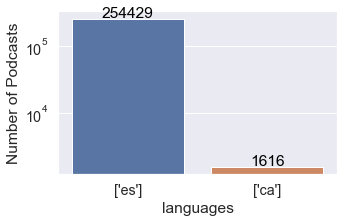

In [24]:
# Languages
plot_count_discrete(podcasts_prep, 'languages', yscale='log', annotate=True, sort=True)

We can see that the dominant language is clearly Spanish. In addition, there are no podcasts that have both languages as their Spotify defined language.
It is quite surprising that the number of podcasts in Spanish is greater than the shows in Catalan by an order of magnitude of 100. According to the *Yearbook of Spanish in the world 2019* published by the *Instituto Cervantes* [8], in 2019 there were a total of 483 million Spanish native speakers and the number of potential speakers exceeded 580 millions. On the other hand, according to the *2018 CAT Report* published by *Plataforma per la Llengua* [9] (an NGO that has the goal of preserving and promoting the use of the Catalan language) there were a total of 13 million Catalan speakers. The relative difference in number of speakers is a lot lower than regarding the number of podcasts published in each of the languages.

##### **Media type**

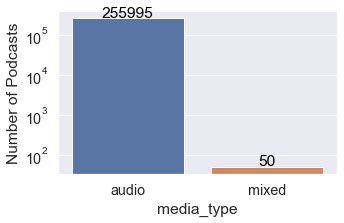

In [25]:
# Media type
plot_count_discrete(podcasts_prep, 'media_type', yscale='log', annotate=True, sort=True)

The number of podcasts of mixed type is residual and almost the whole database consists of audio-only podcasts. This is not so surprising since spotify has been focused on audio since its beginning and it was only on July 2020 that podcast videos were added [10] (mixed media type means that the show is available as video and also as audio-only).

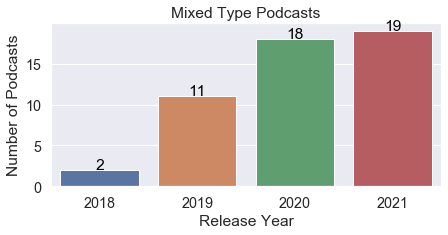

In [26]:
res = podcasts_prep.aggregate([
                                {'$match': {'media_type': 'mixed'}},
                                {'$group': {'_id': f'$release_date.year', 'count': {'$sum': 1}}}
                               ])

df =  pd.DataFrame(list(res))
plot_bars(df, '_id', 'count', 'Release Year', 'Number of Podcasts', title='Mixed Type Podcasts', figsize=(7, 3), annotate=True)

It is seen that there are not any mixed type podcasts from before 2018. As noted, Spotify added podcast videos in 2020. However, since the date of an episode is a field that the publisher can configure, we have mixed type podcasts also in 2018 and 2019.

##### **Explicit**

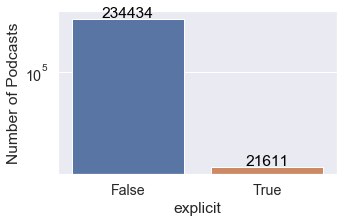

In [27]:
# Explicit content
plot_count_discrete(podcasts_prep, 'explicit', yscale='log', annotate=True, sort=True)

There are about 20,000 podcasts which are flagged as having explicit content. This is just a small fraction of the whole number of podcasts in the dataset.

##### **Date precision**

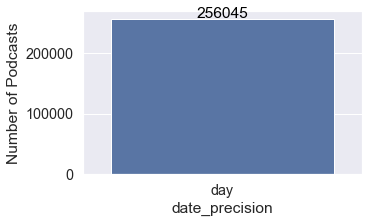

In [28]:
# Date precision
plot_count_discrete(podcasts_prep, 'date_precision', annotate=True, sort=True)

Although this variable could have different values (day, month or year), the date precision for all of the episodes retrieved is day. That means that for all the dates we will have the year, the month and the day.

#### 5.1.2 Numerical Variables

##### **Release date**

For the release date, since the values of the data are discrete, the frequency count is plotted as for the categorical variables. 

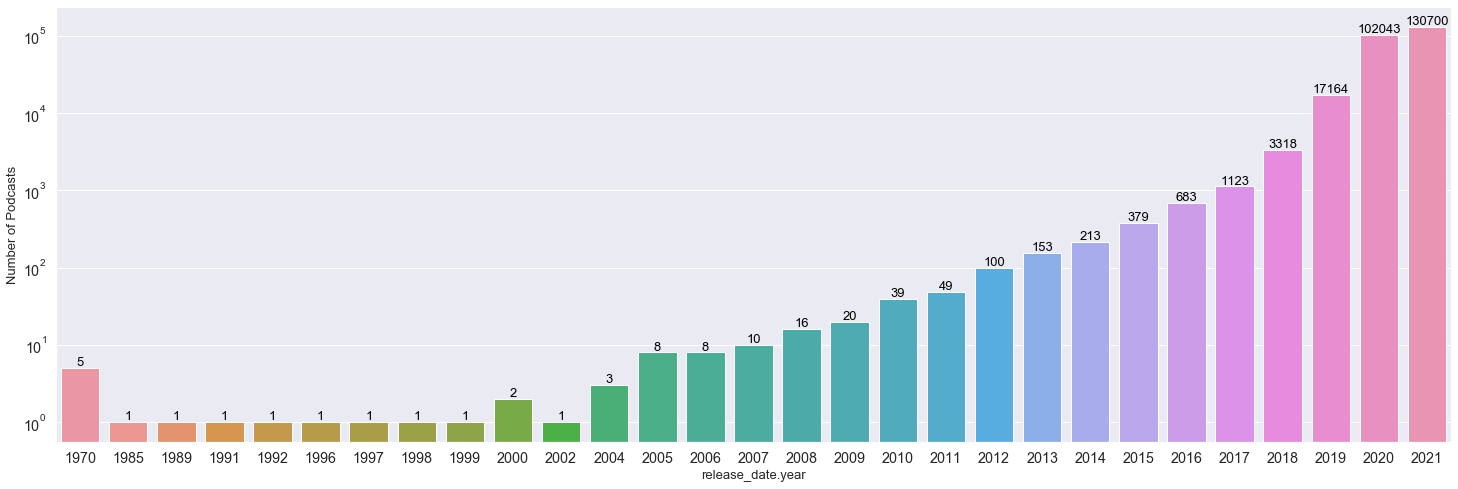

In [29]:
# Release year
plot_count_discrete(podcasts_prep, 'release_date.year', yscale='log', annotate=True, figsize=(25, 8), sort='labels', fontsize=13)

The number of new podcasts grows every year. Surprisingly, there are shows with a release date in the 70s, 80s and 90s. This might be due to an error made by the publisher when setting the date or because old content has been made available online. To really know whether these years are valid, the show should be manually inspected.

The number of shows released in a year doesn't get to 1,000 until 2017, and the number of podcasts released in previous decades is residual and almost insignificant. From there, the number of shows released every year grows exponentially, with the biggest increase being from 2019 to 2020. Then, this last year 2021 the growth has decreased a little bit, although more podcasts have been created overall than in 2020. For this plot, a logarithmic scale has been used in order to be able to better visualize the data corresponding to all years. Further analysisis will be made on this topic, providing more visualizations that help better see and unserstand the evolution of podcasts in time.

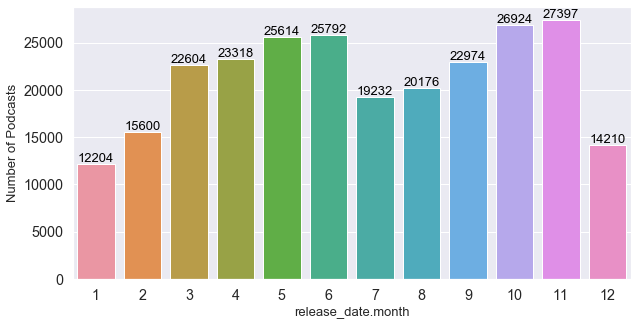

In [30]:
# Release month
plot_count_discrete(podcasts_prep, 'release_date.month', annotate=True, figsize=(10, 5), sort='labels', fontsize=13)

For the release month, there seems to be a pattern that repeats. From January to June, the number of new podcasts released increase for each month. Then, there's a drop in July and it increases again until November. Finally, there's another drop in December.

It looks like the most common months to publish a new podcast are May, June, October and November. On the other hand, the months of December, January, February, July and August are the months when the least amount of new shows are released. We could think that during the Summer and Winter holidays publishers don't release new shows. It is curious, however, to see that the months with the most number of new podcasts are not those *after* the "holiday months" but the months just right *before*.

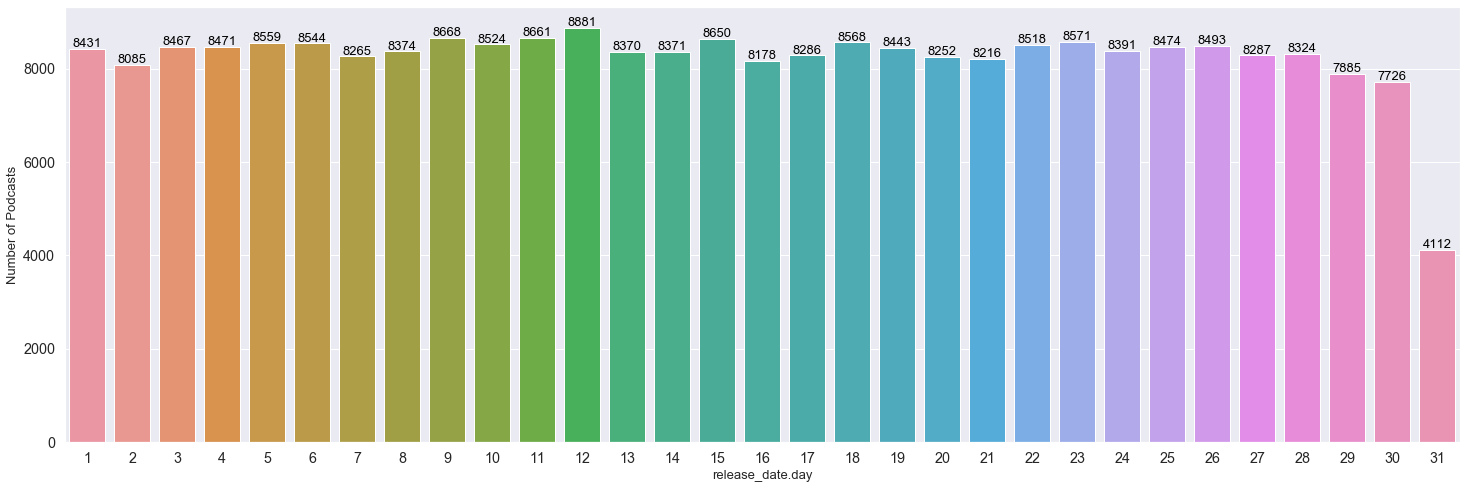

In [31]:
# Release day
plot_count_discrete(podcasts_prep, 'release_date.day', annotate=True, figsize=(25, 8), sort='labels', fontsize=13)

In this case, the days don't make any difference. The only difference, which is obvious, is that there are about the half of new shows released on the 31st, since only 7 months out of 12 have 31 days.

##### **Last date**

Again, since the values of the data are discrete, the frequency count is plotted as for the categorical variables

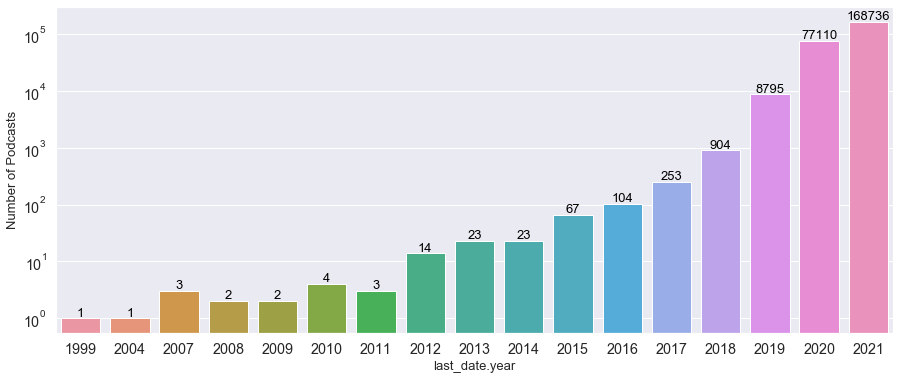

In [32]:
# Last year
plot_count_discrete(podcasts_prep, 'last_date.year', yscale='log', annotate=True, figsize=(15, 6), sort='labels', fontsize=13)

For the last episode year, we see a similar trend as for the release. The number increases over the year, with the highest increase being in 2020. That means that while a lot of new podcasts appeared on 2020, also a lot of shows stopped publishing episodes on that year.

With regards to "old" shows, there are no last episodes on the 70s, 80s or 90s, except for one in the year 1999. That means that either those shows have an error in the release date of their first episode or otherwise, they have been successful throughout the years. The latter makes more sense, since it is possible that shows that exists nowadays want to make old episodes available online. The reason why there are only few shows with their last date on previous decades is because for that cases it means that shows that don't exist anymore have been published online on Spotify, and that is less likely.

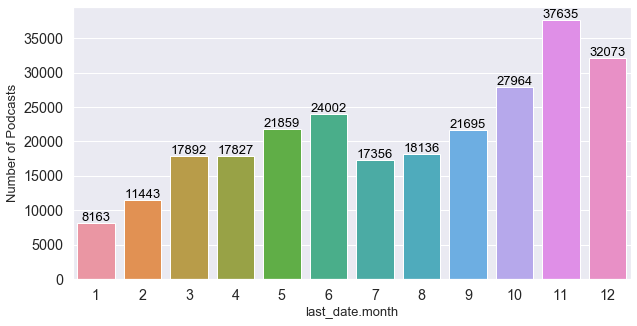

In [33]:
# Last month
plot_count_discrete(podcasts_prep, 'last_date.month', annotate=True, figsize=(10, 5), sort='labels', fontsize=13)

For the last months we can appreciate a very similar pattern to that of the relese month, with the exception of December, where this thime the number of last episodes is higher. This could mean that when new podcasts are created, others are abandonned at the same time.

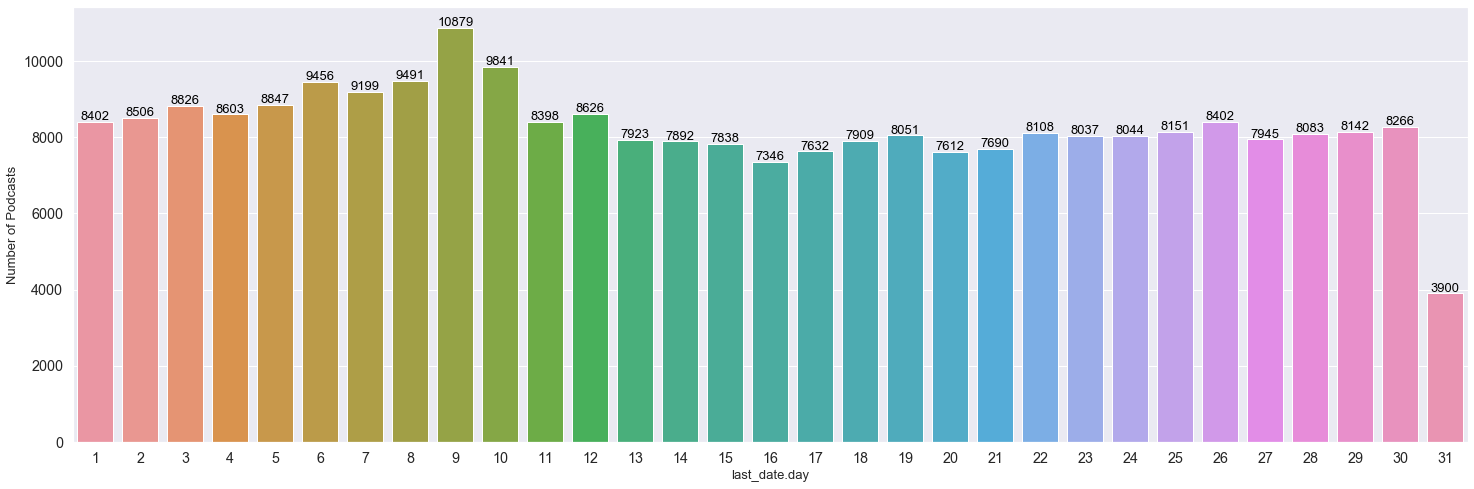

In [34]:
# Last day
plot_count_discrete(podcasts_prep, 'last_date.day', annotate=True, figsize=(25, 8), sort='labels', fontsize=13)

In general, all last days follow the same trend as the release days. Curiously, however, there's a slightly higher value for the 9th, although nothing too strange.

##### **Total episodes**

In [35]:
# Max number of episodes
max_dur = podcasts_prep.find_one({}, {'total_episodes':1, 'name':1, 'id':1}, sort=[("total_episodes", -1)])

print(f"Maximum number of episodes: {max_dur['total_episodes']} ({max_dur['name']})")

Maximum number of episodes: 11276 (Mindalia.com-Salud,Espiritualidad,Conocimiento)


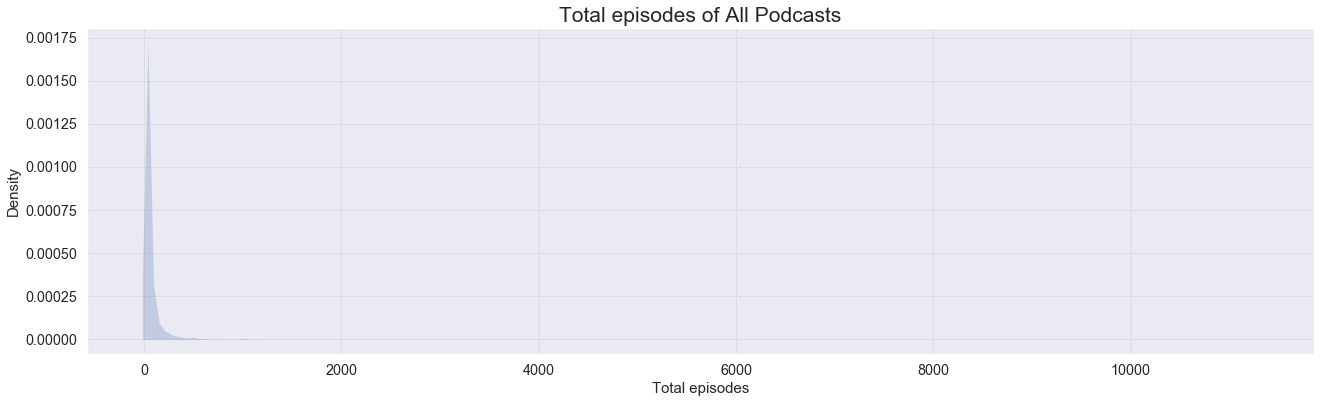

In [36]:
# Get total_episodes of each document (podcast)
res = podcasts_prep.find({}, {'total_episodes': 1})
df =  pd.DataFrame(list(res))
plot_kde(df, x_label="Total episodes", title="Total episodes of All Podcasts", field="total_episodes", figsize=(22, 6), fontsize=15)

There is a show with more than 10,000 episodes that skews the distribution, so let's zoom in to better visualize the data.

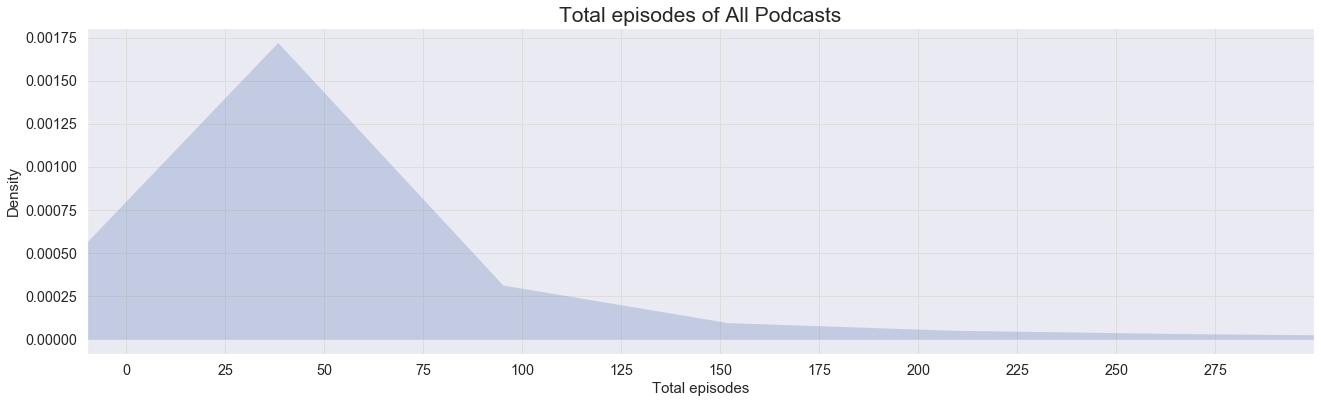

In [37]:
# Zoom in KDE
plot_kde(df, x_label="Total episodes", title="Total episodes of All Podcasts", field="total_episodes", xlim=[-10, 300], xticks=np.arange(0, 300, 25), figsize=(22, 6), fontsize=15)

Most of the podcasts have around 25 and 50 episodes and it is more strange that shows have more than 100 episodes. Let's evaluate the distribution by podcast language.

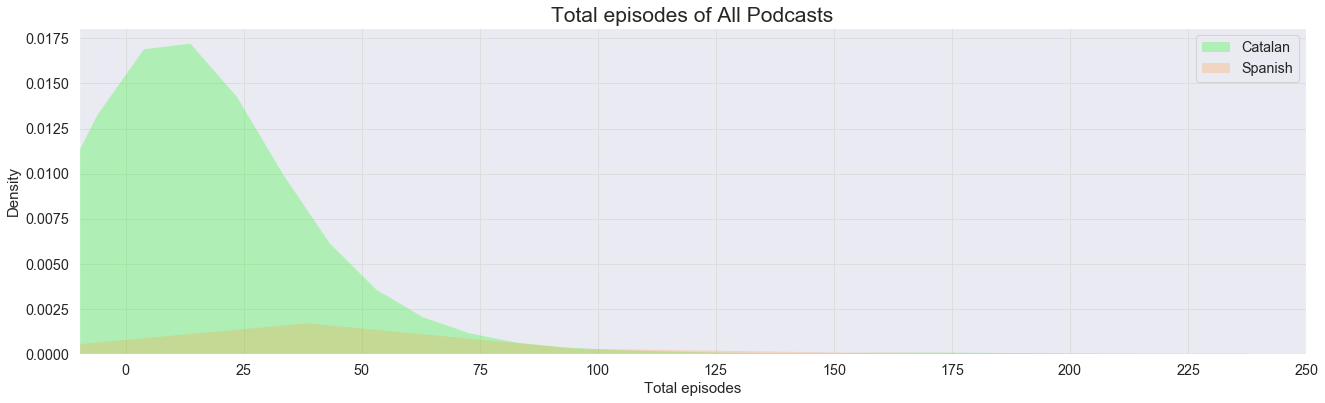

In [38]:
# Get total_episodes and language of each document (podcast)
res = podcasts_prep.find({}, {'name': 1,  'total_episodes': 1, 'languages': 1})
df =  pd.DataFrame(list(res))

# Zoom in KDE
plot_kde(df, x_label="Total episodes", title="Total episodes of All Podcasts", field="total_episodes", xlim=[-10, 250], xticks=np.arange(0, 300, 25), figsize=(22, 6), fontsize=15)

The distribution shows that Catalan shows, in general, have less episodes than Spanish shows.

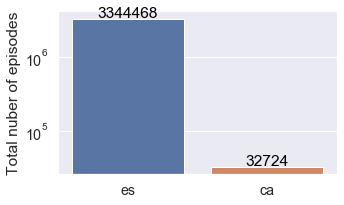

In [39]:
# Total number of episodes by language
pipeline = [
        {'$group': {'_id': '$languages',
                    'total_episodes': {'$sum': "$total_episodes"}}},
        {"$sort": SON([("total_episodes", pymongo.DESCENDING)])},
        {'$limit': 10}
]

res = podcasts_prep.aggregate(pipeline)
df =  pd.DataFrame(list(res))
df['_id'] = df['_id'].transform(func=lambda x: x[0])    # List to int

plot_bars(df, x='_id', y='total_episodes', x_label="", y_label="Total nuber of episodes", yscale='log', annotate=True)


The proportion of episodes in Spanish compared to those in Catalan is similar that for the number of podcasts in each language.

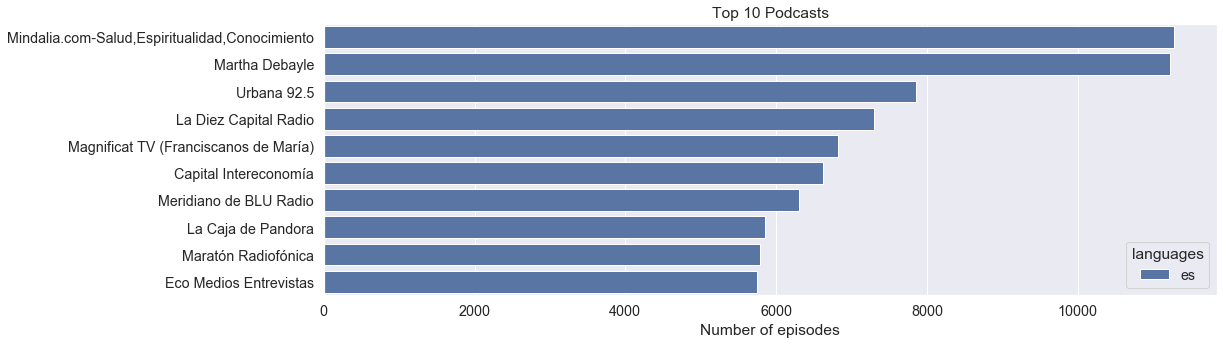

In [40]:
# Plot TOP 10 podcasts by number of episodes
pipeline = [
        {'$group': {'_id': '$name',
                    'languages': {'$addToSet': "$languages"},
                    'total_episodes': {'$addToSet': "$total_episodes"}}},
        {"$sort": SON([("total_episodes", pymongo.DESCENDING)])},
        {'$limit': 10}
]

res = podcasts_prep.aggregate(pipeline)
df =  pd.DataFrame(list(res))

df['total_episodes'] = df['total_episodes'].transform(func=lambda x: x[0])    # List to int
df['languages'] = df['languages'].transform(func=lambda x: x[0][0])    # List to int

plt.figure(figsize=(16,5))
ax = sns.barplot(x='total_episodes', y='_id', data=df, orient='h', hue='languages')

plt.title('Top 10 Podcasts')
plt.xlabel('Number of episodes')
plt.ylabel('')
plt.show()

We see that from the 10 podcasts with the most number of episodes, all of them are in Spanish.

##### **Average duration**

Let's plot a density distribution plot.

In [41]:
# Min and Max total_episodes
max_dur = podcasts_prep.find_one({}, {'average_duration_min':1}, sort=[("average_duration_min", -1)])
min_dur = podcasts_prep.find_one({}, {'average_duration_min':1}, sort=[("average_duration_min", 1)])

print(f"Minimum average episode duration: {min_dur['average_duration_min']}min")
print(f"Maximum average episode duration: {max_dur['average_duration_min']}min")

Minimum average episode duration: 0.5min
Maximum average episode duration: 690.43min


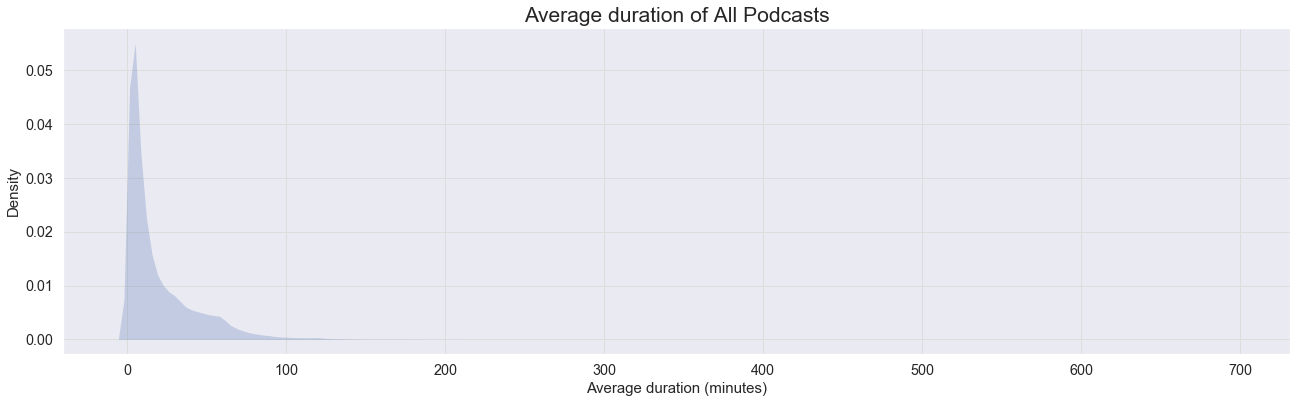

In [42]:
# Get total_episodes of each document (podcast)
res = podcasts_prep.find({}, {'name': 1,  'average_duration_min': 1})
df =  pd.DataFrame(list(res))

plot_kde(df, x_label="Average duration (minutes)", title="Average duration of All Podcasts", field="average_duration_min", figsize=(22, 6), fontsize=15)

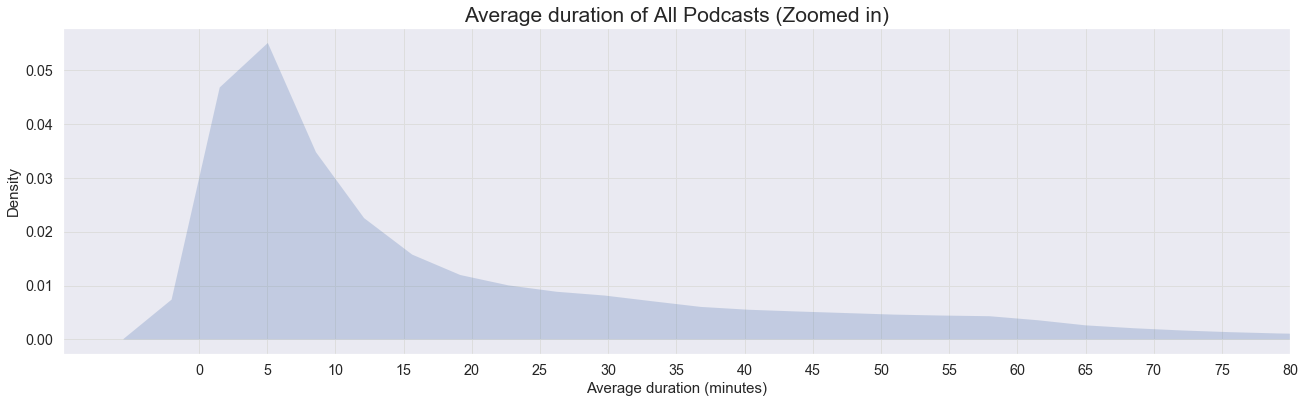

In [43]:
# Zoom in KDE
plot_kde(df, x_label="Average duration (minutes)", title="Average duration of All Podcasts (Zoomed in)", field="average_duration_min", xlim=[-10, 80], xticks=np.arange(0, 90, 5), figsize=(22, 6), fontsize=15)

In [44]:
# Proportion of podcasts that are lower than 10
lt_10 = podcasts_prep.count_documents({'average_duration_min': {'$lte': 10}})
total_pods = podcasts_prep.count_documents({})

print(f'{(lt_10/total_pods)*100:.2f}% of podcasts have an average episode duration lower than 10 minutes.')

50.36% of podcasts have an average episode duration lower than 10 minutes.


The average episode duration of the podcasts in our dataset ranges from 30 seconds to up to more than 11 hours. The lower bound has been determined during the preprocessing, since podcasts with episodes shorter than that have been considered outliers. It is interesting to see that half of the podcasts in the database have a duration of less or equal than 10 minutes. That means that while the catalog contains a lot of podcasts, most of them consist of short episodes. Let's look at the distribution filtering by language.

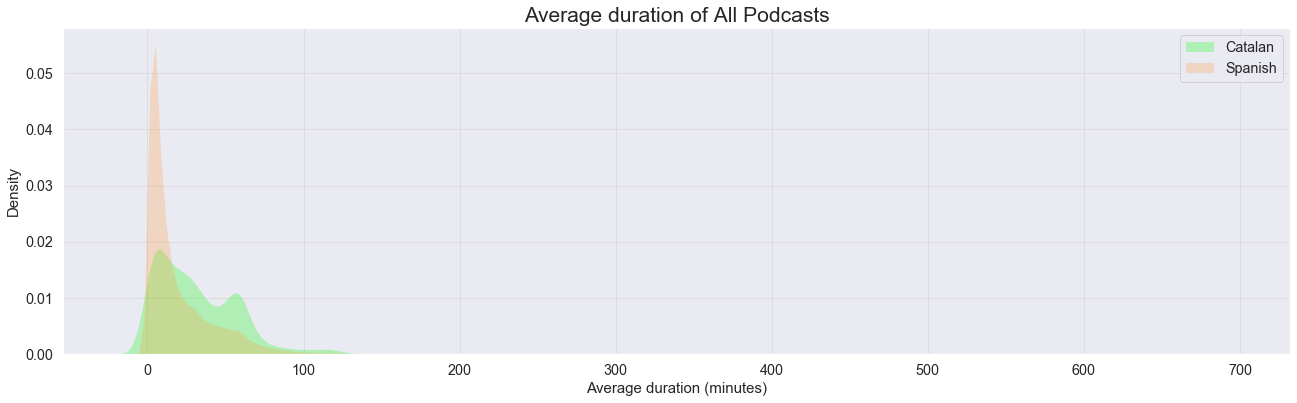

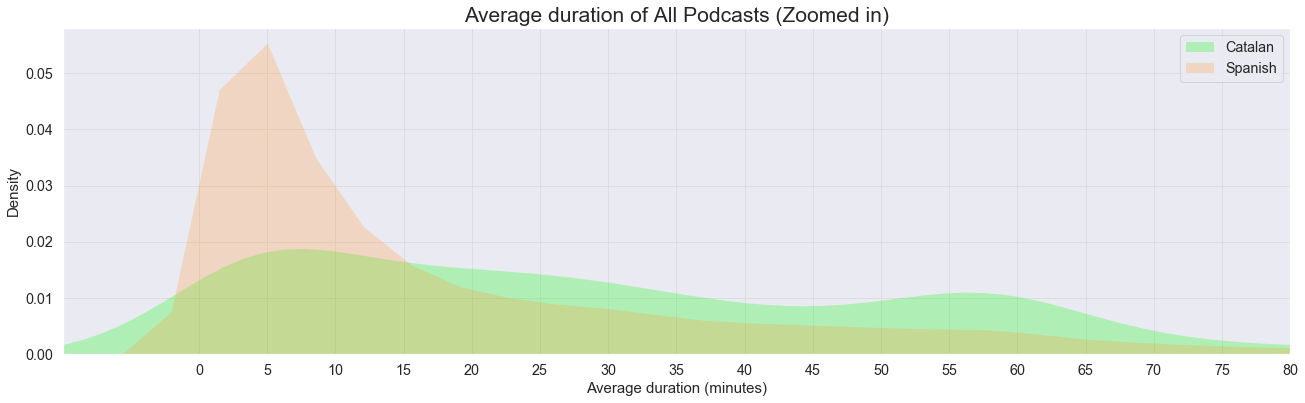

In [45]:
# Get average_duration and language of each document (podcast)
res = podcasts_prep.find({}, {'name': 1,  'average_duration_min': 1, 'languages': 1})
df =  pd.DataFrame(list(res))

plot_kde(df, x_label="Average duration (minutes)", title="Average duration of All Podcasts", field="average_duration_min", figsize=(22, 6), fontsize=15)

# Zoom in KDE
plot_kde(df, x_label="Average duration (minutes)", title="Average duration of All Podcasts (Zoomed in)", field="average_duration_min", xlim=[-10, 80], xticks=np.arange(0, 90, 5), figsize=(22, 6), fontsize=15)

With a boxplot we can also easily visualize the maximum average episode duration.

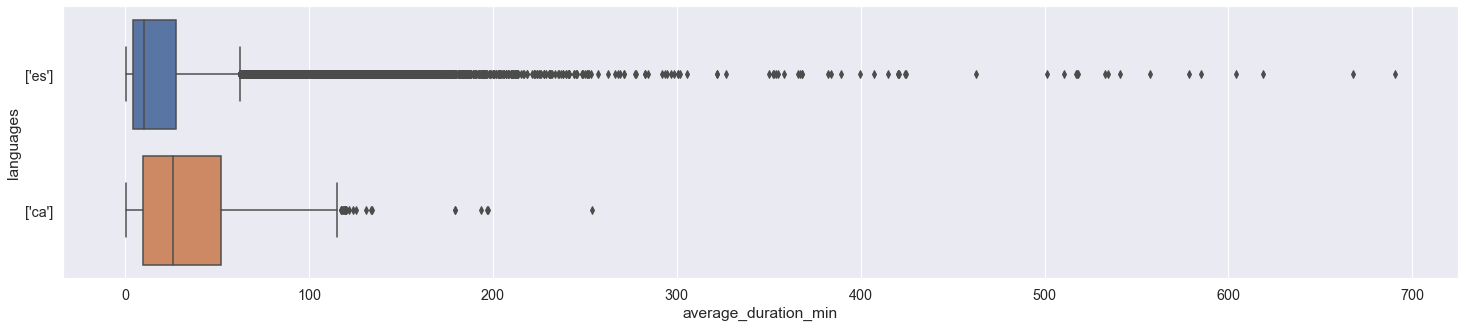

In [46]:
# Boxplots
plt.figure(figsize=(25, 5))
df['languages'] = df['languages'].astype(str)
ax = sns.boxplot(x="average_duration_min", y="languages",  data=df, orient="h")

When filtering by language, we can see that the average duration for podcasts in Catalan is more evenly distributed. There are still a lot of podcasts that have short durations of less 10 minutes but there's also a significant group of podcasts that have an average duration of 50-60 minutes. We can also see that for Catalan the maximum duration is about 4 hours, while for Spanish there are many podcasts that exceed this duration.

In [47]:
# Average duration of episodes by language
pipeline = [
        {'$group': {'_id': '$languages', 'avgDuration': {'$avg': '$average_duration_min'}}},
        {"$sort": SON([("avgDuration", pymongo.DESCENDING)])}    
]

res = podcasts_prep.aggregate(pipeline)
for sample in res:
    print(sample)

{'_id': ['ca'], 'avgDuration': 32.25925123762376}
{'_id': ['es'], 'avgDuration': 19.7208939625593}


In [48]:
# Podcast durations
total_ca = podcasts_prep.count_documents({'languages':['ca']})
total_es  = podcasts_prep.count_documents({'languages':['es']})


# Average duration of equal or less than 10 minutes
pipeline = [
            {'$match': {'average_duration_min': {'$lte': 10}}},
            { "$group": {
                "_id": {"language": "$languages"},
                "count": { "$sum": 1 }
            }}
           ]

res = podcasts_prep.aggregate(pipeline)

res10 = {}
for sample in res:
    res10[sample['_id']['language'][0]] = sample['count']
    

# Average duration of 50-60 minutes
pipeline = [
            {'$match': {'$and': [
                                {'average_duration_min': {'$gte': 50}},
                                {'average_duration_min': {'$gte': 60}},
                                ]}},
            { "$group": {
                "_id": {"language": "$languages"},
                "count": { "$sum": 1 }
            }}
           ]

res = podcasts_prep.aggregate(pipeline)

res50_60 = {}
for sample in res:
    res50_60[sample['_id']['language'][0]] = sample['count']


# Percentages
print(f"Spanish: {res10['es']/total_es*100:.2f}% of podcasts have a duration of 10 minutes or less, {res50_60['es']/total_es*100:.2f}% have a duration of 50-60 minutes.")
print(f"Catalan: {res10['ca']/total_ca*100:.2f}% of podcasts have a duration of 10 minutes or less, {res50_60['ca']/total_ca*100:.2f}% have a duration of 50-60 minutes.")

Spanish: 50.51% of podcasts have a duration of 10 minutes or less, 6.79% have a duration of 50-60 minutes.
Catalan: 25.93% of podcasts have a duration of 10 minutes or less, 13.55% have a duration of 50-60 minutes.


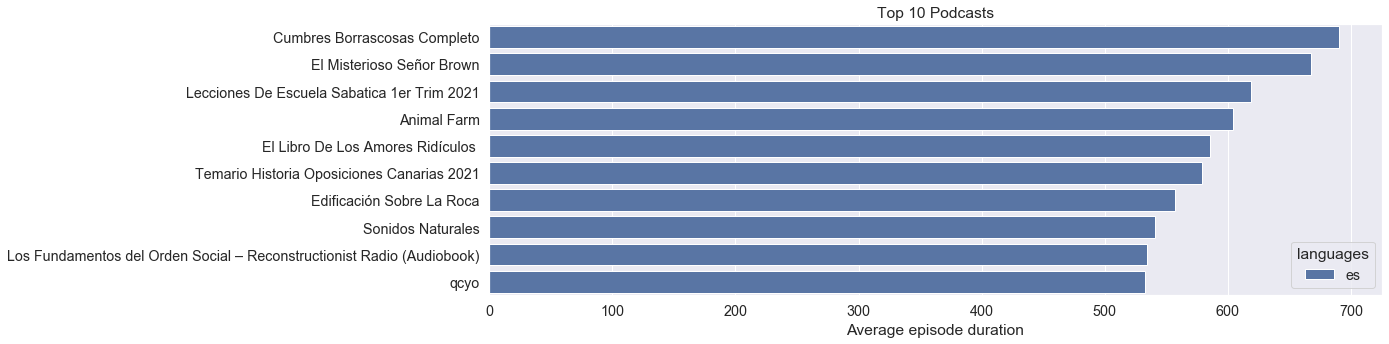

In [49]:
# Plot TOP 10 podcasts by number of episodes
pipeline = [
        {'$group': {'_id': '$name',
                    'languages': {'$addToSet': "$languages"},
                    'average_duration': {'$addToSet': "$average_duration_min"}}},
        {"$sort": SON([("average_duration", pymongo.DESCENDING)])},
        {'$limit': 10}
]

res = podcasts_prep.aggregate(pipeline)
df =  pd.DataFrame(list(res))

df['average_duration'] = df['average_duration'].transform(func=lambda x: x[0])    # List to int
df['languages'] = df['languages'].transform(func=lambda x: x[0][0])    # List to int

plt.figure(figsize=(16,5))
ax = sns.barplot(x='average_duration', y='_id', data=df, orient='h', hue='languages')    

plt.title('Top 10 Podcasts')
plt.xlabel('Average episode duration')
plt.ylabel('')
plt.show()

In the plot above we see the TOP 10 podcasts according to their average episode duration. As we already saw in the boxplots, the shows with the longest average episode duration are in Spanish.

##### **Publisher**

In [50]:
# Group podcasts by publisher
pipeline = [
        {'$group': {'_id': '$publisher', 'num_podcasts': {'$sum': 1}}},
        {"$count": "totalCount"}
]

res = podcasts_prep.aggregate(pipeline)
total_publishers = list(res)[0]['totalCount']

total_podcasts = podcasts_prep.count_documents({})

print(f'There are {total_publishers} different publishers and {total_podcasts} podcasts in database')

There are 224365 different publishers and 256045 podcasts in database


In [51]:
# TOP 10 publisher by number of podcasts
pipeline = [
        {'$group': {'_id': '$publisher',
                    'num_podcasts': {'$sum': 1},
                    'avg_total_episodes': { '$avg': '$total_episodes'},
                    'avg_duration': {'$avg': '$average_duration_min'},
                    'languages': {'$addToSet': "$languages"}}},
        {"$sort": SON([("num_podcasts", pymongo.DESCENDING)])},
        {'$limit': 10}
]

res = podcasts_prep.aggregate(pipeline)
for sample in res:
    print(sample)

{'_id': 'Radio Universidad de Navarra', 'num_podcasts': 244, 'avg_total_episodes': 25.438524590163933, 'avg_duration': 23.159221311475413, 'languages': [['es']]}
{'_id': 'Avance Universitario', 'num_podcasts': 113, 'avg_total_episodes': 1.008849557522124, 'avg_duration': 47.06548672566371, 'languages': [['es']]}
{'_id': 'Carolina', 'num_podcasts': 106, 'avg_total_episodes': 1.669811320754717, 'avg_duration': 8.566792452830189, 'languages': [['es']]}
{'_id': 'Radio Trend Topic', 'num_podcasts': 101, 'avg_total_episodes': 73.58415841584159, 'avg_duration': 45.54633663366337, 'languages': [['es']]}
{'_id': 'Spotify Studios', 'num_podcasts': 96, 'avg_total_episodes': 129.5625, 'avg_duration': 25.055833333333336, 'languages': [['es']]}
{'_id': 'Catalunya Ràdio', 'num_podcasts': 94, 'avg_total_episodes': 44.276595744680854, 'avg_duration': 38.34978723404255, 'languages': [['es'], ['ca']]}
{'_id': 'URosarioRadio', 'num_podcasts': 85, 'avg_total_episodes': 69.29411764705883, 'avg_duration': 59

For the TOP 10 publishers in terms of the number of podcasts they have, we see that other charatersitics such as the average total number of episodes of the podcasts and the average duration of the episodes vary across the different publishers. In second place there is a publisher that has 113 podcasts, which is a high number, but the average number of episodes of the publisher's podcasts are 1. Regarding the average duration, the values are also different for each of the publishers but there are not very extreme values, with most of them having a duration of 40 to 60 minutes approximately. We see that all publishers except for one have podcasts in Spanish. In the case of the publisher _Catalunya Ràdio_ there are podcasts in Catalan and also Spanish.

In [52]:
# TOP 10 publisher by number of podcasts (Catalan)
pipeline = [
        {'$match': {'languages':['ca']}},
        {'$group': {'_id': '$publisher',
                    'num_podcasts': {'$sum': 1},
                    'avg_total_episodes': { '$avg': '$total_episodes'},
                    'avg_duration': {'$avg': '$average_duration_min'}}},
        {"$sort": SON([("num_podcasts", pymongo.DESCENDING)])},
        {'$limit': 10}
]

res = podcasts_prep.aggregate(pipeline)
for sample in res:
    print(sample)

{'_id': 'Catalunya Ràdio', 'num_podcasts': 93, 'avg_total_episodes': 44.215053763440864, 'avg_duration': 38.67204301075269}
{'_id': 'Ràdio Ciutat de Tarragona', 'num_podcasts': 57, 'avg_total_episodes': 9.701754385964913, 'avg_duration': 25.58859649122807}
{'_id': 'RAC1', 'num_podcasts': 29, 'avg_total_episodes': 17.03448275862069, 'avg_duration': 39.89758620689655}
{'_id': 'Ràdio Pollença 107.9', 'num_podcasts': 14, 'avg_total_episodes': 5.357142857142857, 'avg_duration': 40.46}
{'_id': 'LANOVA Ràdio', 'num_podcasts': 13, 'avg_total_episodes': 16.53846153846154, 'avg_duration': 44.660000000000004}
{'_id': 'Cooltura FM', 'num_podcasts': 12, 'avg_total_episodes': 19.166666666666668, 'avg_duration': 65.52666666666667}
{'_id': 'Ràdio Manlleu ', 'num_podcasts': 12, 'avg_total_episodes': 19.916666666666668, 'avg_duration': 40.01}
{'_id': 'Ràdio Sabadell', 'num_podcasts': 11, 'avg_total_episodes': 18.545454545454547, 'avg_duration': 36.04545454545455}
{'_id': 'socdesants', 'num_podcasts': 10

For podcasts in Catalan, we see that there are no TOP publishers with an average number of total episododes per podcast of 1. Also, similar to what has been seen when analyzing the average duration for all podcasts, the TOP podcasts have quite similar average episode duration.

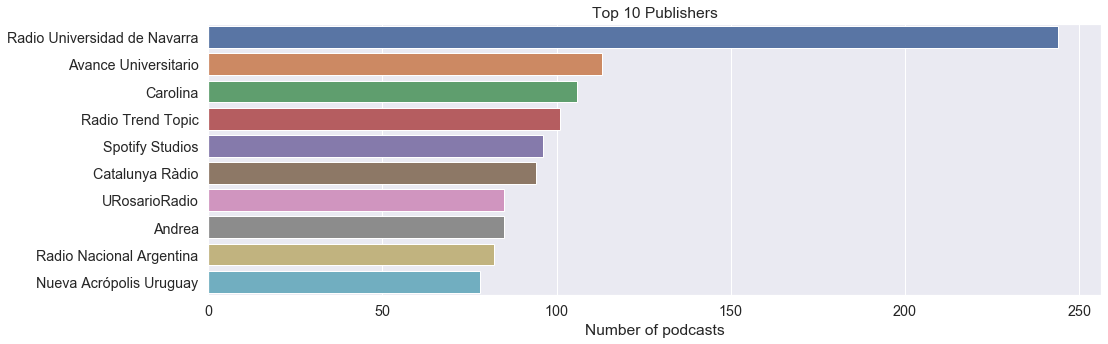

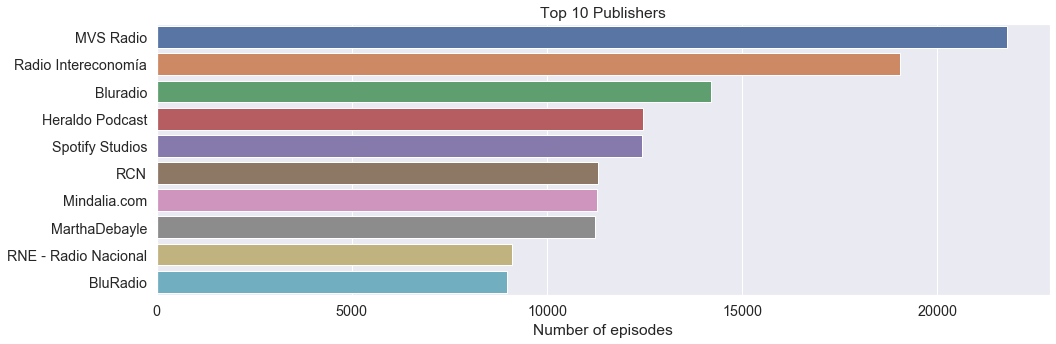

In [53]:
# Plot TOP 10 Publishers by number of podcasts
pipeline = [
        {'$group': {'_id': '$publisher',
                    'num_podcasts': {'$sum': 1}}},
        {"$sort": SON([("num_podcasts", pymongo.DESCENDING)])},
        {'$limit': 10}
]

res = podcasts_prep.aggregate(pipeline)
df =  pd.DataFrame(list(res))

plt.figure(figsize=(16,5))
ax = sns.barplot(x='num_podcasts', y='_id', data=df, orient='h')

plt.title('Top 10 Publishers')
plt.xlabel('Number of podcasts')
plt.ylabel('')
plt.show()

# Plot TOP 10 Publishers by number of episodes
pipeline = [
        {'$group': {'_id': '$publisher',
                    'total_episodes': {'$sum': '$total_episodes'}}},
        {"$sort": SON([("total_episodes", pymongo.DESCENDING)])},
        {'$limit': 10}
]

res = podcasts_prep.aggregate(pipeline)
df =  pd.DataFrame(list(res))

plt.figure(figsize=(16,5))
ax = sns.barplot(x='total_episodes', y='_id', data=df, orient='h')

plt.title('Top 10 Publishers')
plt.xlabel('Number of episodes')
plt.ylabel('')
plt.show()

We can make a ranking of the TOP publishers according to different criteria. If we rank them according to the number of podcasts we see different publisher names than if we rank them by their total number of episodes. It's interesting to see, however, that _Spotify Studios_ is in the same 5th position for both of the rankings.

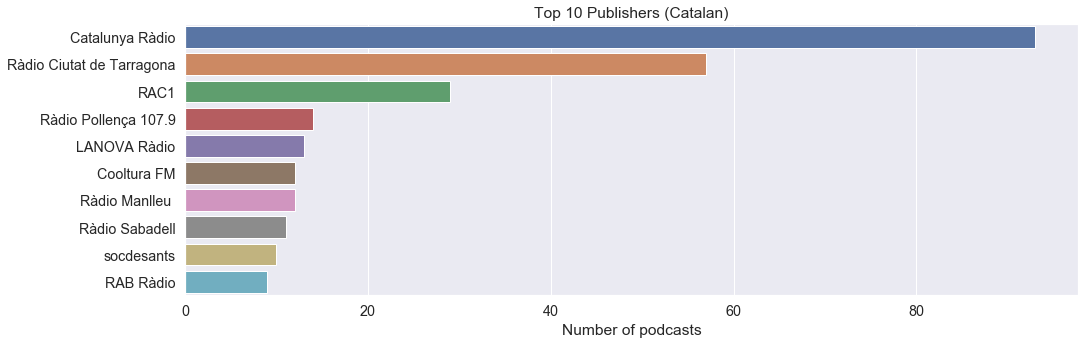

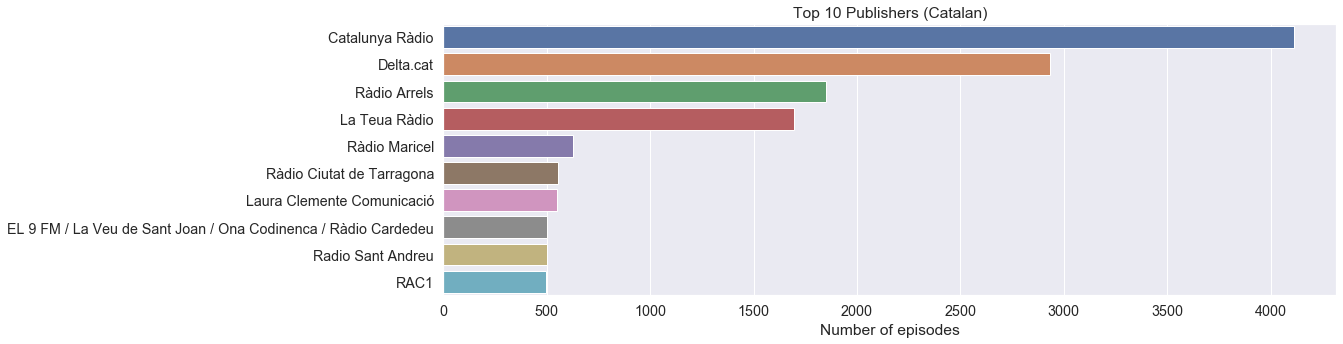

In [54]:
# Plot TOP 10 Publishers by number of podcasts (Catalan)
pipeline = [
        {'$match': {'languages':['ca']}},
        {'$group': {'_id': '$publisher',
                    'num_podcasts': {'$sum': 1}}},
        {"$sort": SON([("num_podcasts", pymongo.DESCENDING)])},
        {'$limit': 10}
]

res = podcasts_prep.aggregate(pipeline)
df =  pd.DataFrame(list(res))

plt.figure(figsize=(16,5))
ax = sns.barplot(x='num_podcasts', y='_id', data=df, orient='h')

plt.title('Top 10 Publishers (Catalan)')
plt.xlabel('Number of podcasts')
plt.ylabel('')
plt.show()

# Plot TOP 10 Publishers by number of episodes
pipeline = [
        {'$match': {'languages':['ca']}},
        {'$group': {'_id': '$publisher',
                    'total_episodes': {'$sum': '$total_episodes'}}},
        {"$sort": SON([("total_episodes", pymongo.DESCENDING)])},
        {'$limit': 10}
]

res = podcasts_prep.aggregate(pipeline)
df =  pd.DataFrame(list(res))

plt.figure(figsize=(16,5))
ax = sns.barplot(x='total_episodes', y='_id', data=df, orient='h')

plt.title('Top 10 Publishers (Catalan)')
plt.xlabel('Number of episodes')
plt.ylabel('')
plt.show()

If we only look at podcasts in Catalan, something similar happens, where both rankings show different publishers with only some exceptions. In this case, the publisher _Catalunya Ràdio_, which corresponds to the public Catalan Radio, leads both rankings, with values that are well above the rest.

##### **Name**

The field with which a user identifies a podcast is by it's name. To analyse the name field we can measure the length of the name and also the frequency distribution of the words used.

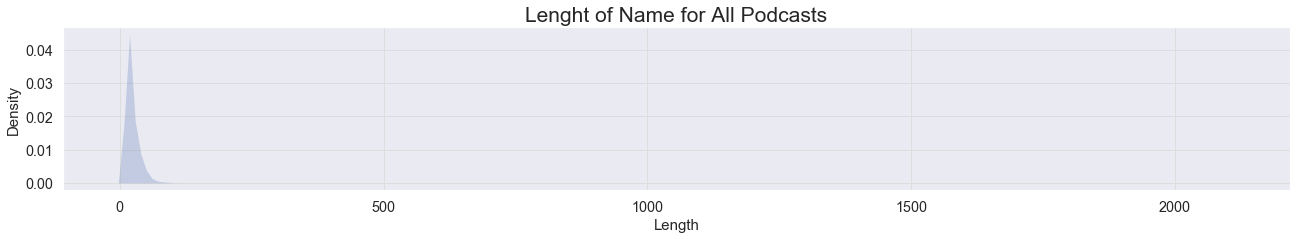

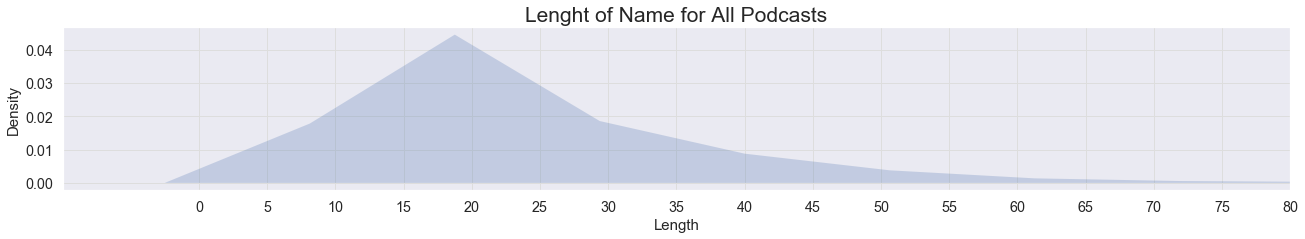

In [55]:
# Group by name and calculate length
pipeline = [
        {'$group': {'_id': '$name',
                    'length': {'$addToSet': {'$strLenCP': '$name'}}}},
        {"$sort": SON([("total_episodes", pymongo.DESCENDING)])},
]

res = podcasts_prep.aggregate(pipeline)
df =  pd.DataFrame(list(res))
df['length'] = df['length'].transform(func=lambda x: x[0])    # List to int

# KDE Plot
plot_kde(df, x_label="Length", title="Lenght of Name for All Podcasts", field="length", figsize=(22, 3), fontsize=15)
plot_kde(df, x_label="Length", title="Lenght of Name for All Podcasts", field="length", xlim=[-10, 80], xticks=np.arange(0, 90, 5), figsize=(22, 3), fontsize=15)

In [56]:
# Longest name
pipeline = [
        {'$group': {'_id': '$name',
                    'length': {'$addToSet': {'$strLenCP': '$name'}},
                    'id': {'$addToSet': '$id'}}},
        {"$sort": SON([("length", pymongo.DESCENDING)])},
        {'$limit': 1}
]

res = podcasts_prep.aggregate(pipeline)
pprint(list(res)[0])

{'_id': 'NPara pegar un clip en el cuadro de texto, tócalo.Despedida (4 min) '
        'Con todo lo mencionado, estoy seguro(a) de que tú vas a lograr tener '
        'un estilo de vida saludable es muy importante pues nos ayudará a '
        'mantenernos fuertes y saludables Finalmente, te invito a realizar '
        'actividades físicas son muy beneficiosos para nuestra vida pues ayuda '
        'a reducir el riesgo de contraer alguna enfermedad. Gracias por '
        'permitirme llegar a ti y nos encontraremos en el próximo capítulo de '
        'tu podcast favorito " tú salud ante todo " y  recuerda… ¡la salud es '
        'una riqueza!Despedida (4 min) Con todo lo mencionado, estoy seguro(a) '
        'de que tú  vas a lograr  tener un estilo de vida saludable es muy '
        'importante pues nos ayudará a mantenernos fuertes y saludables '
        'Finalmente, te invito a realizar actividades físicas son muy '
        'beneficiosos para nuestra vida pues ayuda a reducir el riesg

The typical length of the podcast name falls between 15 and 25 characters. That is well understandable, since podcast names should only consist of few words. However, there are also very long names, of up to more than 2,000 characters, which are more of a description than an actual name. This must be some kind of error, maybe caused by an automatic tool that publishes podcasts do Spotify. A more interessting analysis might be to quantify which are the most used words in a podcast name.

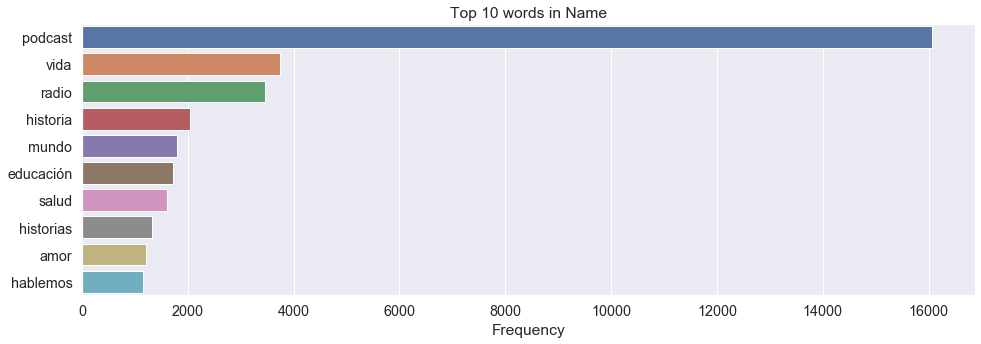

In [57]:
# Bar plot of most common words
df_fdist = freq_dist_from_list(df['_id'])
plt.figure(figsize=(16,5))

ax = sns.barplot(x='Frequency', y='Term', data=df_fdist.iloc[:10,:], orient='h')

plt.title('Top 10 words in Name')
plt.ylabel('')
plt.show()

In the plot above we can easily see which are the most common words used in a podcast name. Without much surprise, _podcast_ is the most used word, well above the rest. The rest of common words can give us an idea of popular podcast topics such as _vida_, _historia_, _educación_, _salud_, etc.

Another way to visualize information about the frquency distribution of the words in the name is to use a wordcloud.

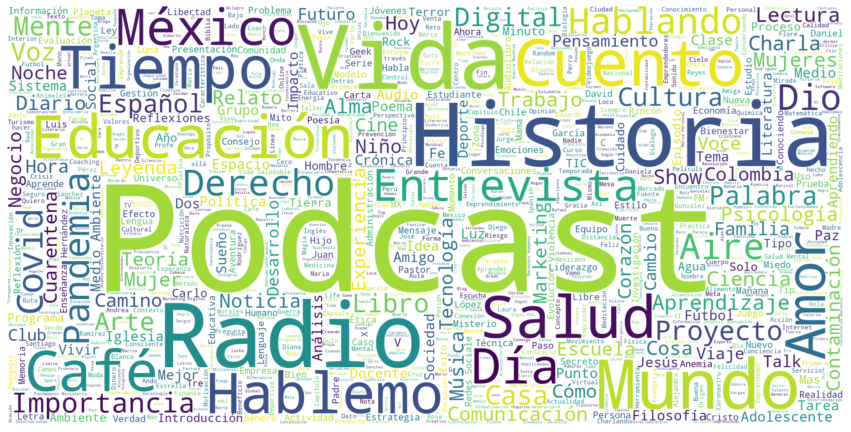

In [58]:
# Word Cloud of most common words
plot_wordcloud(df['_id'])

##### **Description**
The description also gives important information about a podcast. Below, the same analysis as for the name is performed.

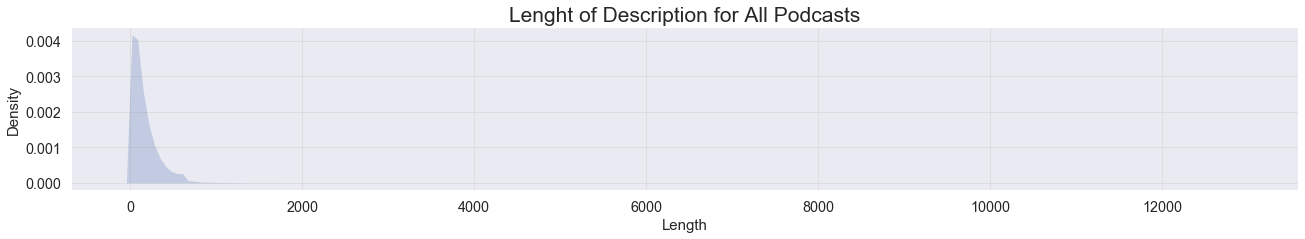

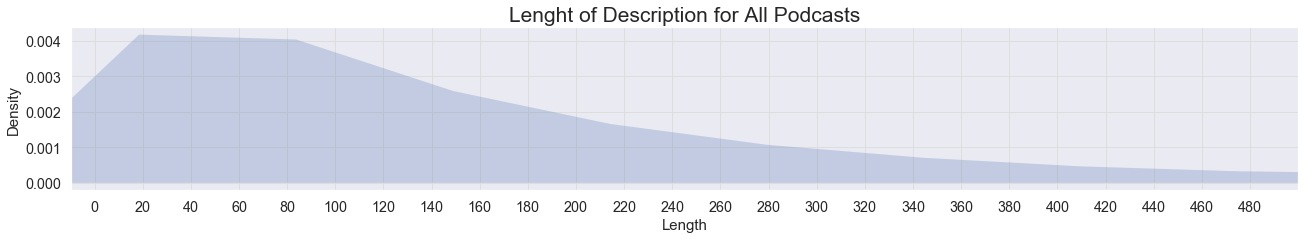

In [59]:
# Group by description and calculate length
pipeline = [
        {'$group': {'_id': '$description',
                    'length': {'$addToSet': {'$strLenCP': '$description'}}}},
]

res = podcasts_prep.aggregate(pipeline)
df =  pd.DataFrame(list(res))
df['length'] = df['length'].transform(func=lambda x: x[0])    # List to int

# KDE Plot
plot_kde(df, x_label="Length", title="Lenght of Description for All Podcasts", field="length", figsize=(22, 3), fontsize=15)
plot_kde(df, x_label="Length", title="Lenght of Description for All Podcasts", field="length", xlim=[-10, 500], xticks=np.arange(0, 500, 20), figsize=(22, 3), fontsize=15)

Regarding descriptions, most podcasts have descriptions of a length ranging from 20 to 100 characters. Longer descriptions are not so common, although there are also some podcasts which have very long descriptions of up to 12,000 characters. As for the name, a more interessting analysis might be to quantify which are the most common words used in podcast descriptions.

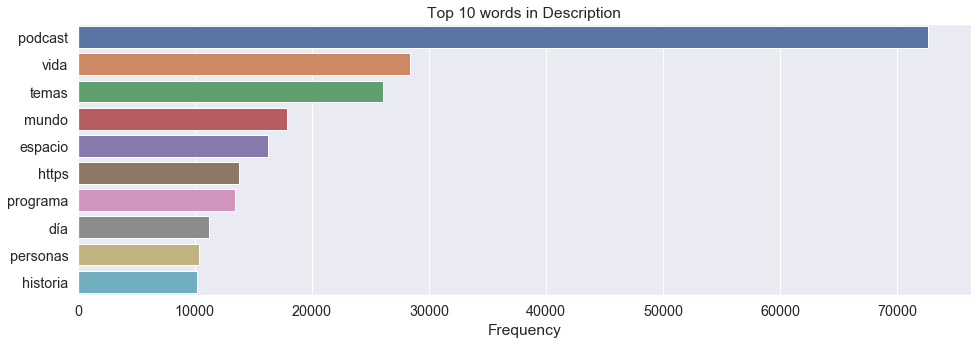

In [60]:
# Bar plot of most common words
df_fdist = freq_dist_from_list(df['_id'])
plt.figure(figsize=(16,5))

ax = sns.barplot(x='Frequency', y='Term', data=df_fdist.iloc[:10,:], orient='h')

plt.title('Top 10 words in Description')
plt.ylabel('')
plt.show()

As expected, _podcast_ is again the most used word in podcast descriptions and curiously, _vida_ occupies the 2nd place in both rankings. The rest of the words also give some information about possible topics but a lot of them are words that refer to the podcast without giving extra information, such as _programa_, _espacio_, _día_ or _temas_. In 6th place there's _https_, which shows that it is quite common for podcasts to add a website hyperlink in their descriptions.

Another way to visualize information about the frequency distribution of the words in the description is to use a wordcloud.

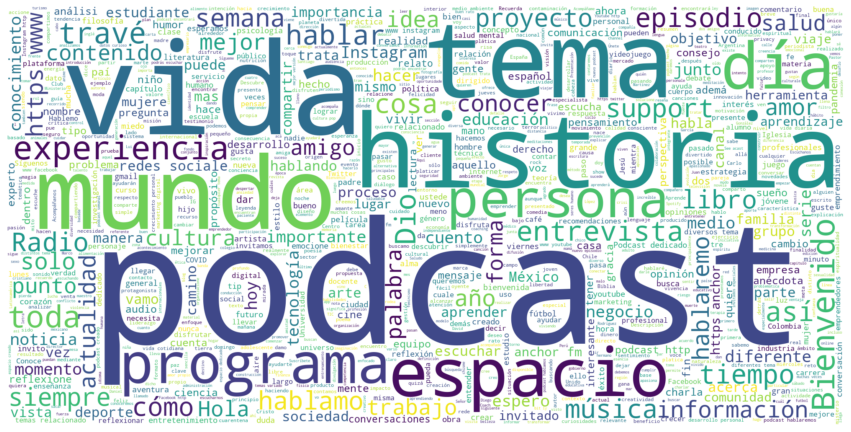

In [61]:
# Word Cloud of most common words
plot_wordcloud(df['_id'])

### 5.2. Extended Analysis

By performing an initial yet thorough exploratory data analysis, we've been able to get a first impression of the dataset and the information thath each of the fields provide.

Now, an extended but briefer analysis will be made with the goal of extracting further information about the topics that appear to be more interesting and also with the aim of getting more knowledge about the field of podcasts and to be able to answer some of the initial questions. Has there really been an increase in the number of podcasts published in the recent couple of years? Has the COVID pandemic had any influence on the podcast market?

To start, let's plot a timeline of podcasts releases since 2019.

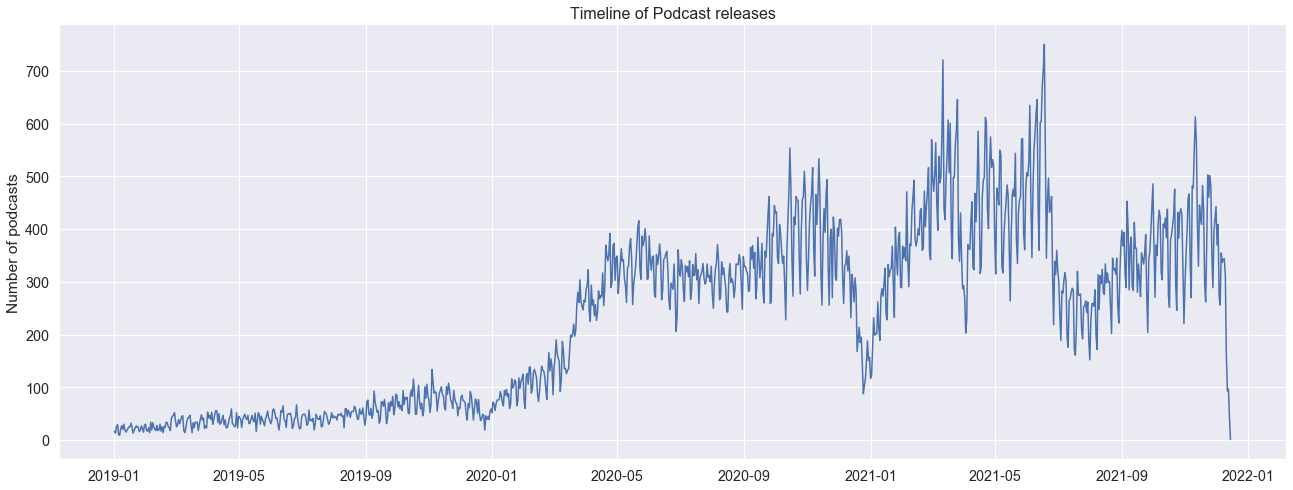

In [62]:
# Number of podcasts released at each date (after 2019)
res = podcasts_prep.aggregate([{'$match': {'release_date.year': {'$gte': 2019}}},
                               {'$group': {'_id': '$ReleaseDate', 'count': {'$sum': 1}, 
                                           'languages': {'$addToSet': "$languages"}}},
                            ])
df =  pd.DataFrame(list(res))

plt.figure(figsize=(22,8))
sns.lineplot(data=df, x="_id", y="count")
plt.xlabel('')
plt.ylabel('Number of podcasts')
plt.title('Timeline of Podcast releases', fontsize=16)
plt.show()

This timeline shows us how the growth of the number of published podcasts started at the end of 2019. Until the May of 2020 there was a big increase and then the growth has been maintained, with a decrease around the end of the year and a higher increase for 2021.

Let's plot the same information by language.

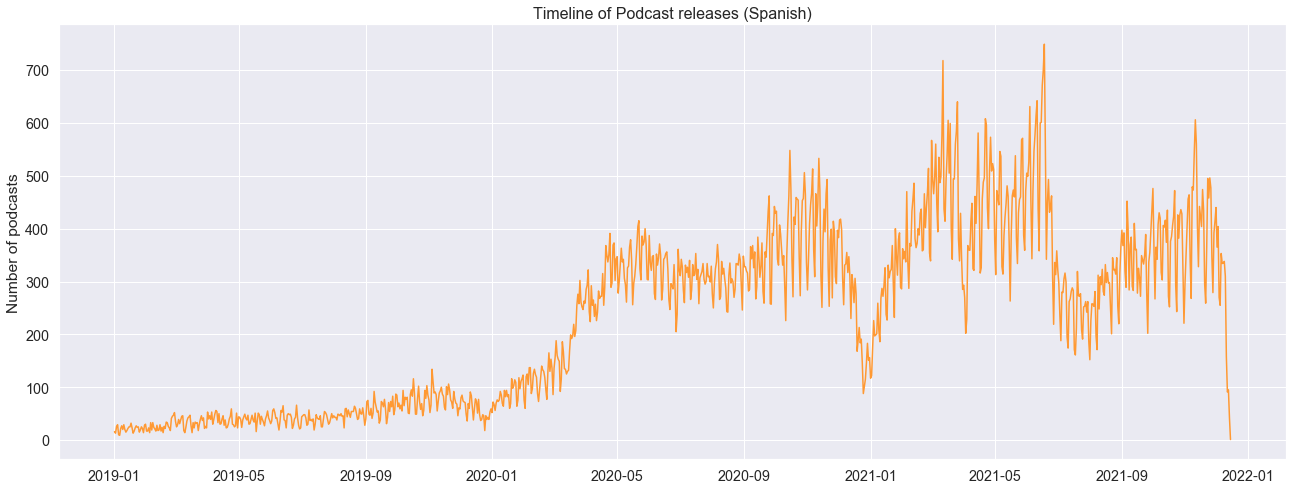

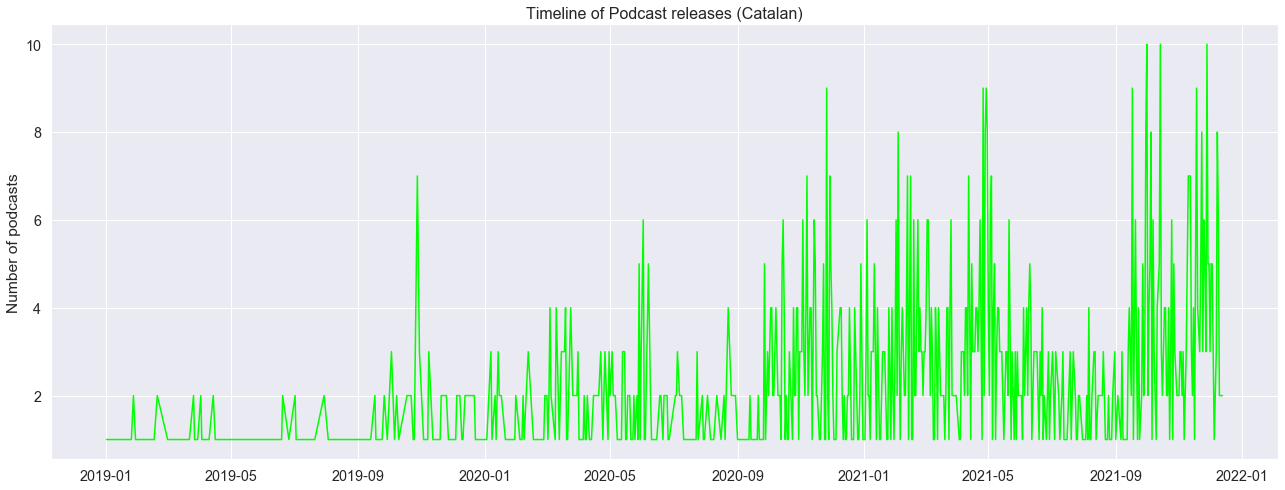

In [63]:
# Number of podcasts released at each date (after 2019), by language
res = podcasts_prep.aggregate([{'$match': {'release_date.year': {'$gte': 2019}}},
                               {'$group': {'_id': {
                                                    "date": "$ReleaseDate",
                                                    "lang": "$languages"
                                                  },
                                           'count': {'$sum': 1}, 
                                           'languages': {'$addToSet': "$languages"},
                                           'ReleaseDate': {'$addToSet': "$ReleaseDate"}}},
                            ])
df =  pd.DataFrame(list(res))

df['languages'] = df['languages'].transform(func=lambda x: x[0][0])    # List to int
df['ReleaseDate'] = df['ReleaseDate'].transform(func=lambda x: x[0])

ca_df = df[df['languages']=="ca"]
es_df = df[df['languages']=="es"]


# Line Plot Spanish
plt.figure(figsize=(22,8))
sns.lineplot(data=es_df, x="ReleaseDate", y="count", color='#ff9933')
plt.xlabel('')
plt.ylabel('Number of podcasts')
plt.title('Timeline of Podcast releases (Spanish)', fontsize=16)
plt.show()

# Line Plot Catalan
plt.figure(figsize=(22,8))
sns.lineplot(data=ca_df, x="ReleaseDate", y="count", color='#00ff00')
plt.xlabel('')
plt.ylabel('Number of podcasts')
plt.title('Timeline of Podcast releases (Catalan)', fontsize=16)
plt.show()

As the number of Catalan released podcasts is much lower, the timeline has a lot of spikes and is more complicated to see the trend. However, the growth of podcasts releases in 2020 and 2021 is clear.

Next, let's evaluate the lifespan of podcasts.

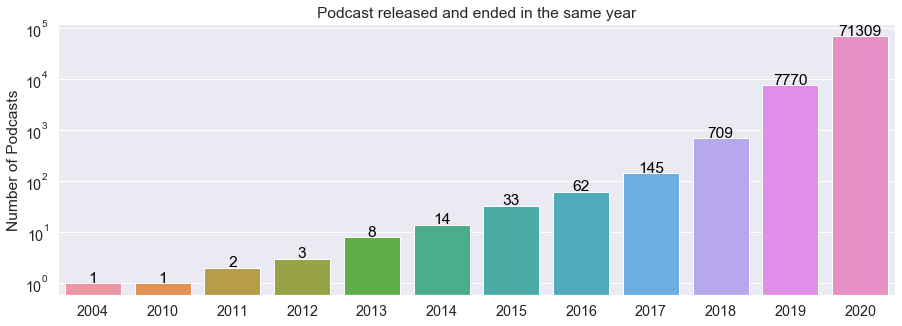

In [64]:
# Podcasts that were released and finished in the same year
pipeline = [
        {'$match': {'$and': [
                                {'release_date.year': {'$ne': 2021}},
                                {'$expr':{'$eq':["$release_date.year", "$last_date.year"]}}
                            ]}},
        {'$group': {'_id': '$release_date.year',
                    'num_podcasts': {'$sum': 1}}},
        {"$sort": SON([("num_podcasts", pymongo.DESCENDING)])}
]


res = podcasts_prep.aggregate(pipeline)
df =  pd.DataFrame(list(res))
plot_bars(df, x='_id', y='num_podcasts', x_label="", y_label="Number of Podcasts", title="Podcast released and ended in the same year", yscale='log', figsize=(15, 5), annotate=True)



In section 5.1.2 we've seen that as more podcasts are released, the number of podcasts that end also increases. In addition, the plot above shows that every year the number of podcasts that are released and finished in the same year also increases. This gives a sense of the brief nature of a lot of the podcasts that are created nowadays.

We can also use the ```$dateDiff``` MongoDB aggregation function to calculate the timespan of each podcasts, that is how long a show has been active. Then we can analyse which shows have published episodes for the longest time.

In [65]:
# Longest running podcasts
pipeline = [
        {'$group': 
         {'_id': '$id',
          'timespan': {'$addToSet': {'$dateDiff': {'startDate': '$ReleaseDate', 'endDate': '$LastDate', 'unit': 'year'}}},
          'name': {'$addToSet': '$name'},
          'ReleaseDate': {'$addToSet': '$release_date.year'}}},
        {"$sort": SON([("timespan", pymongo.DESCENDING)])},
        {'$limit': 10}
    ]

res = podcasts_prep.aggregate(pipeline)
for sample in res:
    print(sample)

{'_id': '5PB7OE17O05Fh3IFR6IDzx', 'timespan': [51], 'name': [' La Hora Rockdelux '], 'ReleaseDate': [1970]}
{'_id': '2Vq3f5Gf1LklLehAQ9trys', 'timespan': [51], 'name': ['PASTOR ALVARO VALENCIA'], 'ReleaseDate': [1970]}
{'_id': '4VHfNY640VSSgwmDjxGN8L', 'timespan': [51], 'name': ["La chronique en Catalan de L'APLEC"], 'ReleaseDate': [1970]}
{'_id': '0nK5whap7pQ4i9nUbODjS6', 'timespan': [51], 'name': ['Directo Podcast'], 'ReleaseDate': [1970]}
{'_id': '1Ny6n68eSYH1PivH5l2WRN', 'timespan': [49], 'name': ['Cristo Rey Candelaria'], 'ReleaseDate': [1970]}
{'_id': '2l1zuYJF5Rzvs8yn47ipfE', 'timespan': [36], 'name': ['El Mundo en nuestra Antena'], 'ReleaseDate': [1985]}
{'_id': '02Xky8xpp9f8AkpCEbKEIL', 'timespan': [29], 'name': ['La casa de la palabra'], 'ReleaseDate': [1992]}
{'_id': '1tORPUA5kIRXqcbzDfjITH', 'timespan': [28], 'name': ['La Voz de la Piedra Angular'], 'ReleaseDate': [1991]}
{'_id': '6JMljrgvv2f4wlBK40So57', 'timespan': [24], 'name': ['Johnny Rodríguez'], 'ReleaseDate': [1996]

The TOP 5 shows were first released in 1970 and are still running today, which is really strange. We can most certainly consider 1970 an outlier. This is confirmed when accessing the shows in Spotify using their id. Episodes with a release year in 1970 don't have any information in their description about the authenticity of the date.

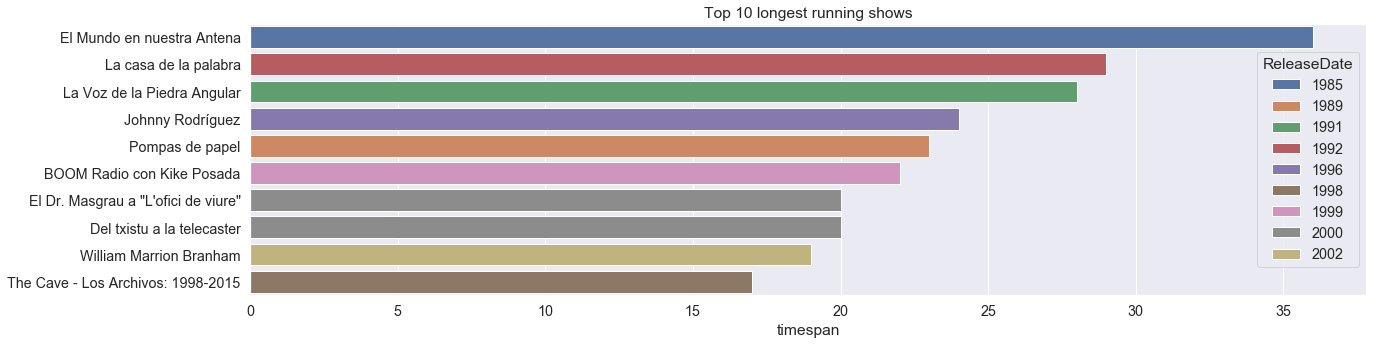

In [66]:
# Longest running podcasts
pipeline = [
        {'$match': {'release_date.year': {'$gt': 1970}}},
        {'$group': 
         {'_id': '$id',
          'timespan': {'$addToSet': {'$dateDiff': {'startDate': '$ReleaseDate', 'endDate': '$LastDate', 'unit': 'year'}}},
          'name': {'$addToSet': '$name'},
          'ReleaseDate': {'$addToSet': '$release_date.year'}}},
        {"$sort": SON([("timespan", pymongo.DESCENDING)])},
        {'$limit': 10}
    ]

res = podcasts_prep.aggregate(pipeline)
df = pd.DataFrame(list(res))

df['timespan'] = df['timespan'].transform(func=lambda x: x[0])    # List to int
df['ReleaseDate'] = df['ReleaseDate'].transform(func=lambda x: x[0])
df['name'] = df['name'].transform(func=lambda x: x[0])

plt.figure(figsize=(20,5))
ax = sns.barplot(x='timespan', y='name', data=df, orient='h', hue='ReleaseDate', dodge=False)

plt.title('Top 10 longest running shows')
plt.ylabel('')
plt.show()

It is still surprising that there are shows that have been running for decades, but now we shall assume that the dates are correct and that our results are right. For example, the last podcast name gives us a hint that the date must be correct. For the others, they could be manually checked in Spotify to see if the episode description gives any idea of the actual release date.

Finally, we can evaluate the presence of words related to the Covid-19 pandemic in the names and descriptions of podcasts.

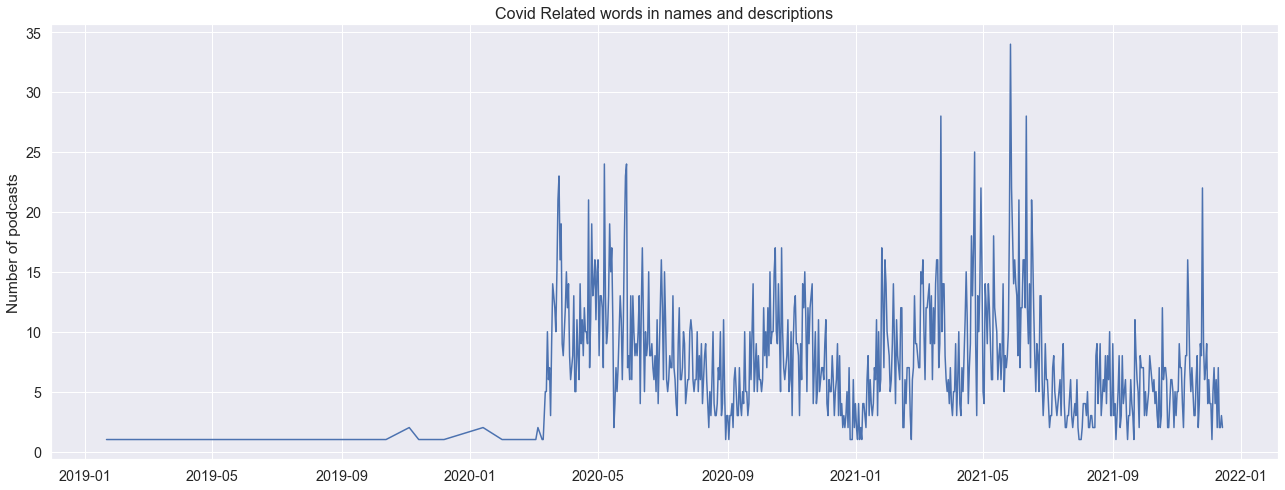

In [68]:
# Use MongoDB regex to filter for words related to the Covid-19 pandemic
pipeline = [
            {'$match': {'$and': [
                                {'release_date.year': {'$gte': 2019}},
                                {'$or': [{ "name": { '$regex': '(coronavirus)', '$options': 'i'}},
                                         { "name": { '$regex': '(covid)', '$options': 'i'}},
                                         { "name": { '$regex': '(pandemia)', '$options': 'i'}},
                                         { "name": { '$regex': '(pandèmia)', '$options': 'i'}},
                                         { "name": { '$regex': '(sars-cov)', '$options': 'i'}},
                                         { "name": { '$regex': '(confin)', '$options': 'i'}},
                                         { "description": { '$regex': '(coronavirus)', '$options': 'i'}},
                                         { "description": { '$regex': '(covid)', '$options': 'i'}},
                                         { "description": { '$regex': '(pandemia)', '$options': 'i'}},
                                         { "description": { '$regex': '(pandèmia)', '$options': 'i'}},
                                         { "description": { '$regex': '(sars-cov)', '$options': 'i'}},
                                         { "name": { '$regex': '(confin)', '$options': 'i'}},

                                        ]}
                            ]}},
            {"$group": {"_id": '$ReleaseDate',
                        "count": {"$sum": 1}}}
            ]

res = podcasts_prep.aggregate(pipeline)
df = pd.DataFrame(list(res))

plt.figure(figsize=(22,8))
sns.lineplot(data=df, x="_id", y="count",)
plt.xlabel('')
plt.ylabel('Number of podcasts')
plt.title('Covid Related words in names and descriptions', fontsize=16)
plt.show()

We can see that when the lockdown started in Spain in mid March, the appearance of words related to the pandemic started to grow. The presence of these words has oscilated over the following months, with some peaks around July 2021 followed by a decrease. Recently, there's been some peaks around November, which conicide with the increase of positive Covid cases.

## 6. Conclusions

Having developed this project has given me the oportunity to apply the fundamentals of the content learned in the subject Big Data Analytics. On one side, I have done a data gathering task by building a dataset by using web APIs and web scraping tools. This has been one of the most complicated parts. After deciding _how_ to obtain the data, the process itself was not free of errors. When performing this kind of data gathering and web scraping it is normal to face various problems and this project has proven to be a good way to deal with a real world problem. Next, after preprocessing the data, the second big part of the project has been the analysis. In this part, various techniques learned in the guided labs have been applied, most of them being related to the use of MongoDB. In addition, many of the visualization tools explained in the theory class have been used in practice using Python.

Regarding the analysis, we can conclude that there has in fact been a high growth in the number of podcasts published since the end of 2019, with an increasing trend in the following years. It has also been observed that the release of new podcasts is also affected by the month of the year, with it decreasing in winter and summer. At the same time that new podcasts appear every year, the number of podcasts that are released and ended in the same year also increases. It is interesting, though, that there are podcasts in Spotify that have been "on air" for decades.

There are about 150 times more podcasts in Spanish than in Catalan, although the difference in speakers is of lower magnitude. However, it has been observed that while there are many shows in Spanish with episodes of a duration of less than 10 minutes, it is more typical for Catalan shows to have episode durations of 40 to 60 minutes than it is for Spanish. For Spanish, the publishers with more podcasts and with a highest number of total published episodes are not the same with the noticeable exception of _Spotify Studios_, which ranks 7th in both cases. In the case of Catalan podcasts, the public radio's publisher _Catalunya Ràdio_ leads both rankings and is well beyond the second place publisher.

Regarding the words used in names and descriptions, _podcast_ is the most common word overall. Followed by that, common words found in the name express information about topics or categories such as history, education, life and health. For the description, the most common words give general information about the podcast such as day, program, themes and persons. When looking at the appearance of words related to Covid-19 in the name and description of podcasts, it is interesting to see its evolution, starting to grow around the time the Spanish lock-down started.

Finally, it has to be acknowledged that the dataset had some limitations. On the one hand, its completeness. Because of the methods used, and as mentioned in Sectoin 2, the datast does not include the whole Spotify catalog. In addition, there are some characteristics of podcasts, such as the genre, which are not present in the dataset due to the limitations of the Spotify API. On top of that, there is an instrinsic bias on the data, because we are using a dataset made with data from Spotify to try to extract conclusions for the whole podcast market. However, although the number of fields is not very high and despite the limitations just mentioned, the gathered data has been useful to extract insightful information and knowledge about the current podcasts market and its evolution. For future work it would be nice to gather a bigger dataset, which included more languages and also information about each of the podcast episodes. If a source other than Spotify was scraped, then a better dataset which included categories and number of reproductions or popularity could be also made.

## References
[1] Brown, J. (2020). **Search, browse and follow podcasts using the new Podcast APIs.**  _Spotify for Developers._ Retrieved 21 December 2021, from https://developer.spotify.com/community/news/2020/03/20/introducing-podcasts-api/

[2] Instituto Cervantes (2019). **EL ESPAÑOL: UNA LENGUA VIVA INFORME 2019.** Retrieved 21 December 2021, from https://cvc.cervantes.es/lengua/espanol_lengua_viva/pdf/espanol_lengua_viva_2019.pdf

[3] Apple (2021). **Enrollment-Support.** _Apple Developer._ Retrieved 21 December 2021, from https://developer.apple.com/support/enrollment/

[4] Spotify (2020). **Web API Documentation.** _Spotify for Developers._ Retrieved 21 December 2021, from https://developer.spotify.com/documentation/web-api

[5] Spotify (2021). **Spotify Shareholders Letter.** _U.S. Securities and Exchange Comission._ Retrieved 1 December 2021, from https://www.sec.gov/Archives/edgar/data/1639920/000119312521308632/d174858dex991.htm

[6] Podchaser (2021). **Podcast Database Startup Podchaser Raises $4M.** _Podchaser Articles_ Retrieved 21 December 2021, from https://www.podchaser.com/articles/inside-podchaser/podchaser-raises-4m

[7] Apple (2021). **Podcasts Descargas en iTunes.** _Apple Podcasts._ Retrieved 21 December 2021, from https://podcasts.apple.com/es/genre/podcasts/id26

[8] Plataforma per la Llengua (2018). **Informe CAT 2018 - 50 dades sobre la llengua catalana.** Retrieved 21 December 2021, from https://www.plataforma-llengua.cat/media/upload/pdf/informecat2018_1528713023.pdf

[9] Perez, S. (2021). **Spotify's new Podcast Subscriptions expand to global markets.** _Yahoo Finance._ Retrieved 1 December 2021, from https://finance.yahoo.com/news/spotifys-podcast-subscriptions-expand-global-173408899.html

[10] Spotify. (2020). **Spotify Fans Can Better Connect to Creators With New Video Podcasts.** _Spotify Newsroom._ Retrieved 21 December 2021, from https://newsroom.spotify.com/2020-07-21/spotify-fans-can-better-connect-to-creators-with-new-video-podcasts/